# Optimisation de Portefeuille - Théorie de Markowitz

**Auteur:** Hassan EL QADI  
**Date:** 11 Décembre 2025  
**Institution:** ENSA Agadir

---

## Résumé Exécutif

Ce projet présente une étude complète de l'optimisation de portefeuille basée sur la théorie moderne de portefeuille (MPT) développée par Harry Markowitz. 

**Objectifs du projet :**

1. **Collecter et analyser** les données historiques de prix d'actifs financiers
2. **Étudier les propriétés statistiques** des séries de prix et de rendements
3. **Construire des portefeuilles optimaux** selon différents critères:
   - Portefeuille à variance minimale
   - Portefeuille Mean-Variance
   - Portefeuille tangent (maximum Sharpe ratio)
4. **Évaluer la performance** à travers diverses métriques de risque et rendement
5. **Valider les résultats** par backtesting sur données hors-échantillon
6. **Analyser le risque** avec VaR, CVaR et Maximum Drawdown

L'étude démontre que l'optimisation quantitative améliore significativement le couple rendement-risque par rapport à des approches naïves, tout en soulignant les limites pratiques de la MPT (sensibilité aux estimations, non-normalité des rendements).

## 1. Configuration et Importation des Bibliothèques

In [1]:
# Bibliothèques essentielles
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader.data as web
from scipy.optimize import minimize
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Configuration d'affichage
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.precision', 4)
plt.rcParams['figure.figsize'] = (14, 7)
np.random.seed(42)

print("✓ Configuration terminée")

✓ Configuration terminée


## 2. Collecte et Préparation des Données

### Sélection des Actifs

Le portefeuille comprend **6 actifs** couvrant différentes classes d'investissement pour une **diversification optimale** :

**Actions (60% du potentiel):**
- **QQQ** (Nasdaq 100): Technologies américaines à forte croissance
- **VTI** (Total US Market): Large base diversifiée du marché américain
- **VWO** (Emerging Markets): Marchés émergents pour diversification géographique

**Actifs Défensifs (40% du potentiel):**
- **GLD** (Gold): Protection contre l'inflation et les crises
- **VNQ** (Real Estate): Immobilier américain coté
- **IEF** (US Treasury 7-10 ans): Obligations gouvernementales comme stabilisateur

---

### Rationale de la Sélection

- **Diversification** entre croissance (QQQ, VTI), marchés émergents (VWO) et actifs défensifs (GLD, IEF, VNQ)
- **Décorrélation** : réactions différentes aux cycles économiques
- **Stabilité** : portefeuille équilibré sans actifs extrêmes

---

### Période d'Étude

- **Entraînement**: 01/01/2018 → 31/12/2024 (7 ans)
- **Backtest**: 01/01/2025 → aujourd'hui

**Phases couvertes:**
- 2018-2019: Croissance stable
- 2020: Crise COVID-19
- 2021: Reprise forte
- 2022-2023: Inflation et hausse des taux
- 2024: Normalisation
- 2025+: Test hors-échantillon

**➡️** Cette structure permet de tester la robustesse des stratégies sur différents régimes de marché.

In [2]:
# Définition des actifs et périodes
tickers = ["QQQ", "VTI", "VWO", "GLD", "VNQ", "IEF"]
start_date = datetime(2018, 1, 1)
end_date = datetime(2024, 12, 31)
backtest_start = datetime(2025, 1, 1)
backtest_end = datetime.now()

# Téléchargement des données
data = yf.download(tickers, start=start_date, end=backtest_end, progress=False)['Close']
data_clean = data.dropna()

# Séparation training/test
data_train = data_clean[data_clean.index <= end_date]
data_test = data_clean[data_clean.index > end_date]

# Taux sans risque
try:
    rf_series = web.DataReader("DTB3", "fred", start_date, backtest_end)
    risk_free_rate = (rf_series.mean().iloc[0] / 100).round(4)
except:
    risk_free_rate = 0.02

# Affichage du résumé
print(f"{'='*70}\nACTIFS: {', '.join(tickers)}\n{'='*70}")
print(f" PÉRIODE D'ENTRAÎNEMENT: {data_train.index[0].date()} → {data_train.index[-1].date()} ({len(data_train)} jours)")
print(f" PÉRIODE DE BACKTEST: {data_test.index[0].date()} → {data_test.index[-1].date()} ({len(data_test)} jours)")
print(f" Taux sans risque: {risk_free_rate*100:.2f}%\n{'='*70}")

ACTIFS: QQQ, VTI, VWO, GLD, VNQ, IEF
 PÉRIODE D'ENTRAÎNEMENT: 2018-01-02 → 2024-12-31 (1761 jours)
 PÉRIODE DE BACKTEST: 2025-01-02 → 2025-12-10 (236 jours)
 Taux sans risque: 2.56%


## 3. Analyse des Propriétés Statistiques

### 3.1 Analyse des Prix

Les séries de prix d'actifs financiers présentent généralement les caractéristiques suivantes:
- **Non-stationnarité**: La moyenne et la variance évoluent dans le temps
- **Tendance**: Présence de drift (tendance à la hausse ou à la baisse)
- **Autocorrélation**: Les prix sont corrélés avec leurs valeurs passées
<!-- - **Volatility clustering**: Périodes de forte/faible volatilité -->

Ces propriétés rendent l'analyse directe des prix problématique pour la modélisation financière.

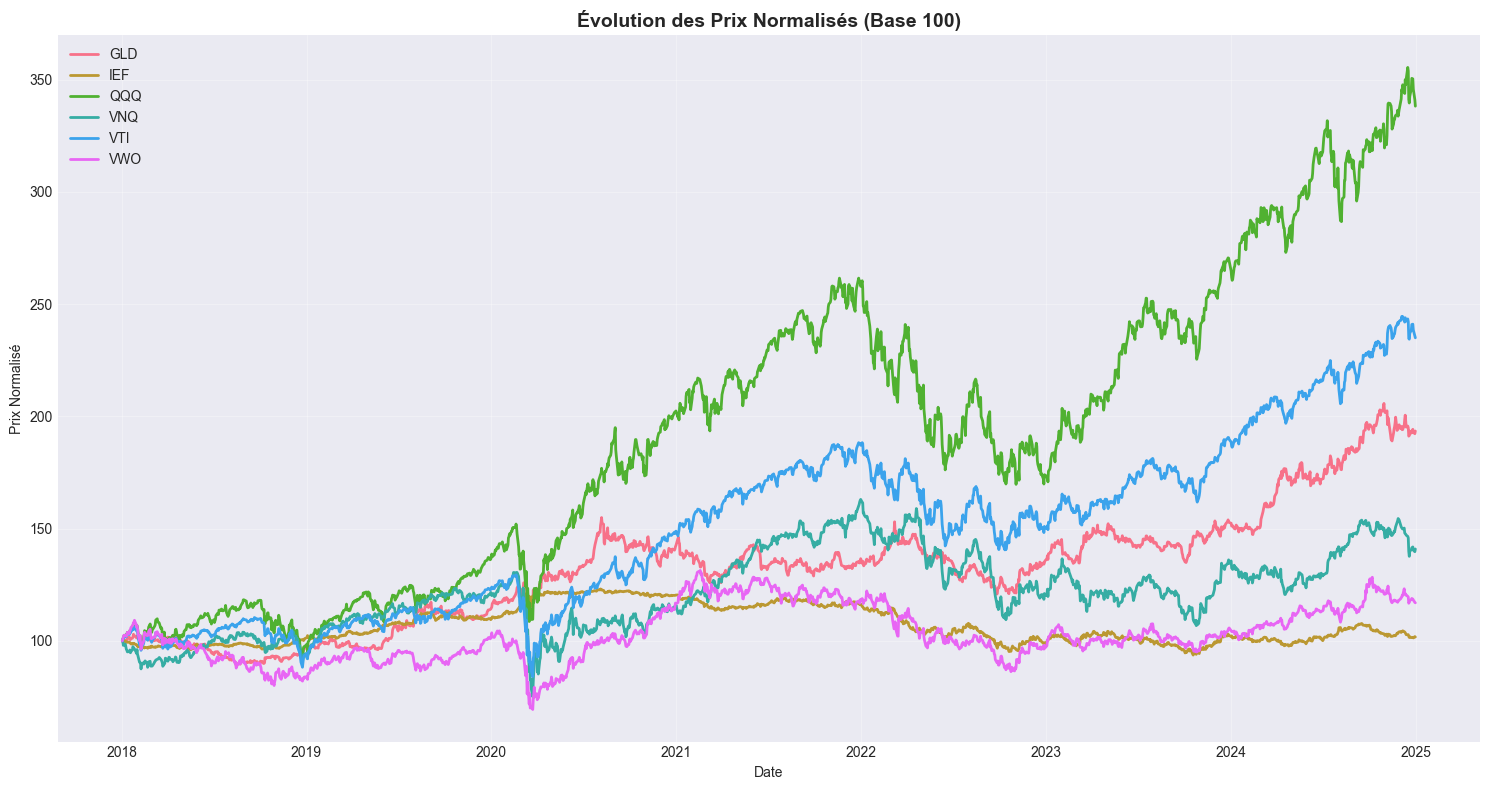


📈 Variation totale sur la période (%):


Ticker,GLD,IEF,QQQ,VNQ,VTI,VWO
Variation Totale (%),93.4718,1.7143,238.1723,40.9347,134.991,16.952


In [3]:
# Visualisation de l'évolution des prix (normalisés à 100)
prices_normalized = (data_train / data_train.iloc[0]) * 100

plt.figure(figsize=(15, 8))
for column in prices_normalized.columns:
    plt.plot(prices_normalized.index, prices_normalized[column], label=column, linewidth=2)
plt.title('Évolution des Prix Normalisés (Base 100)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Prix Normalisé')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Variation totale
total_return = ((data_train.iloc[-1] / data_train.iloc[0]) - 1) * 100
print("\n📈 Variation totale sur la période (%):")
display(total_return.to_frame('Variation Totale (%)').T)

#### Test de stationnarité (Augmented Dickey-Fuller) :

In [4]:
# Test de stationnarité (Augmented Dickey-Fuller)
def adf_test(series, name):
    result = adfuller(series.dropna())
    return {
        'Actif': name,
        'Statistique ADF': result[0],
        'p-value': result[1],
        'Stationnaire (α=5%)': 'Oui' if result[1] < 0.05 else 'Non'
    }

print("TEST DE STATIONNARITÉ (AUGMENTED DICKEY-FULLER)")
print("="*70)
print("H0: Série non-stationnaire (racine unitaire)")
print("H1: Série stationnaire\n")

adf_results = [adf_test(data_train[col], col) for col in data_train.columns]
display(pd.DataFrame(adf_results))

TEST DE STATIONNARITÉ (AUGMENTED DICKEY-FULLER)
H0: Série non-stationnaire (racine unitaire)
H1: Série stationnaire



,Actif,Statistique ADF,p-value,Stationnaire (α=5%)
0,GLD,0.0783,0.9645,Non
1,IEF,-1.3004,0.6290,Non
2,QQQ,0.1273,0.9679,Non
3,VNQ,-2.1273,0.2337,Non
4,VTI,0.0777,0.9645,Non
5,VWO,-1.7994,0.3807,Non


**Interprétation des résultats ADF:**

Les séries de prix sont généralement **non-stationnaires** (p-value > 0.05), ce qui confirme:
- Présence de tendances et de drifts
- Variance non constante dans le temps
- Autocorrélation significative

➡️ **Conclusion**: L'utilisation directe des prix pour l'optimisation de portefeuille n'est pas appropriée. Nous devons travailler avec les **rendements** qui, eux, sont généralement stationnaires.

## 3.2 Analyse des Rendements

### Calcul des Rendements

Deux approches principales existent pour calculer les rendements :

#### **1. Rendements simples (arithmétiques)**

$$R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$$

**Exemple** : Si une action passe de 100€ à 110€, le rendement simple est :
$$R = \frac{110 - 100}{100} = 0.10 = 10\%$$

**Propriété importante** : Les rendements simples sont **additifs en coupe transversale** (pour un portefeuille) :
$$R_p = \sum_{i=1}^{n} w_i R_i$$

où $w_i$ est le poids de l'actif $i$ dans le portefeuille.

#### **2. Rendements logarithmiques (log-returns)**

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) = \ln(P_t) - \ln(P_{t-1})$$

**Exemple** : Pour le même cas (100€ → 110€) :
$$r = \ln(1.10) = 0.0953 = 9.53\%$$


### Avantages des Log-Returns

| Propriété | Rendements Simples | Rendements Logarithmiques |
|-----------|-------------------|---------------------------|
| **Additivité temporelle** | Non : $R_{t,t+2} \neq R_t + R_{t+1}$ | **Oui** : $r_{t,t+2} = r_t + r_{t+1}$ |
| **Symétrie** | Non : +10% puis -10% ≠ 0 | **Oui** : $r(A→B) = -r(B→A)$ |
| **Distribution** | Asymétrique | Plus proche de la normale |
| **Bornes** | $[-1, +\infty]$ | $]-\infty, +\infty[$ |


#### **Additivité Temporelle : Exemple**

**Scénario** : Prix initial 100€, puis +10%, puis +5%

**Avec rendements simples** :
- Jour 1 : $R_1 = 10\%$
- Jour 2 : $R_2 = 5\%$
- Prix final : $100 \times 1.10 \times 1.05 = 115.5€$
- Rendement total : $R_{total} = 15.5\%$ ≠ $R_1 + R_2 = 15\%$ ❌

**Avec rendements logarithmiques** :
- Jour 1 : $r_1 = \ln(1.10) = 0.0953$
- Jour 2 : $r_2 = \ln(1.05) = 0.0488$
- Rendement total : $r_{total} = r_1 + r_2 = 0.1441 = 14.41\%$ ✅
- Vérification : $100 \times e^{0.1441} = 115.5€$ ✅

### Pourquoi utiliser les log-returns dans notre étude ?

1. **Propriétés statistiques** : Distribution plus proche de la normale
2. **Additivité temporelle** : Simplifie les calculs de rendements cumulés
3. **Symétrie** : Traitement équitable des gains et pertes

In [5]:
# Calcul des rendements logarithmiques
returns = np.log(data_train / data_train.shift(1))
returns = returns.dropna()

returns_test = np.log(data_test / data_test.shift(1))
returns_test = returns_test.dropna()

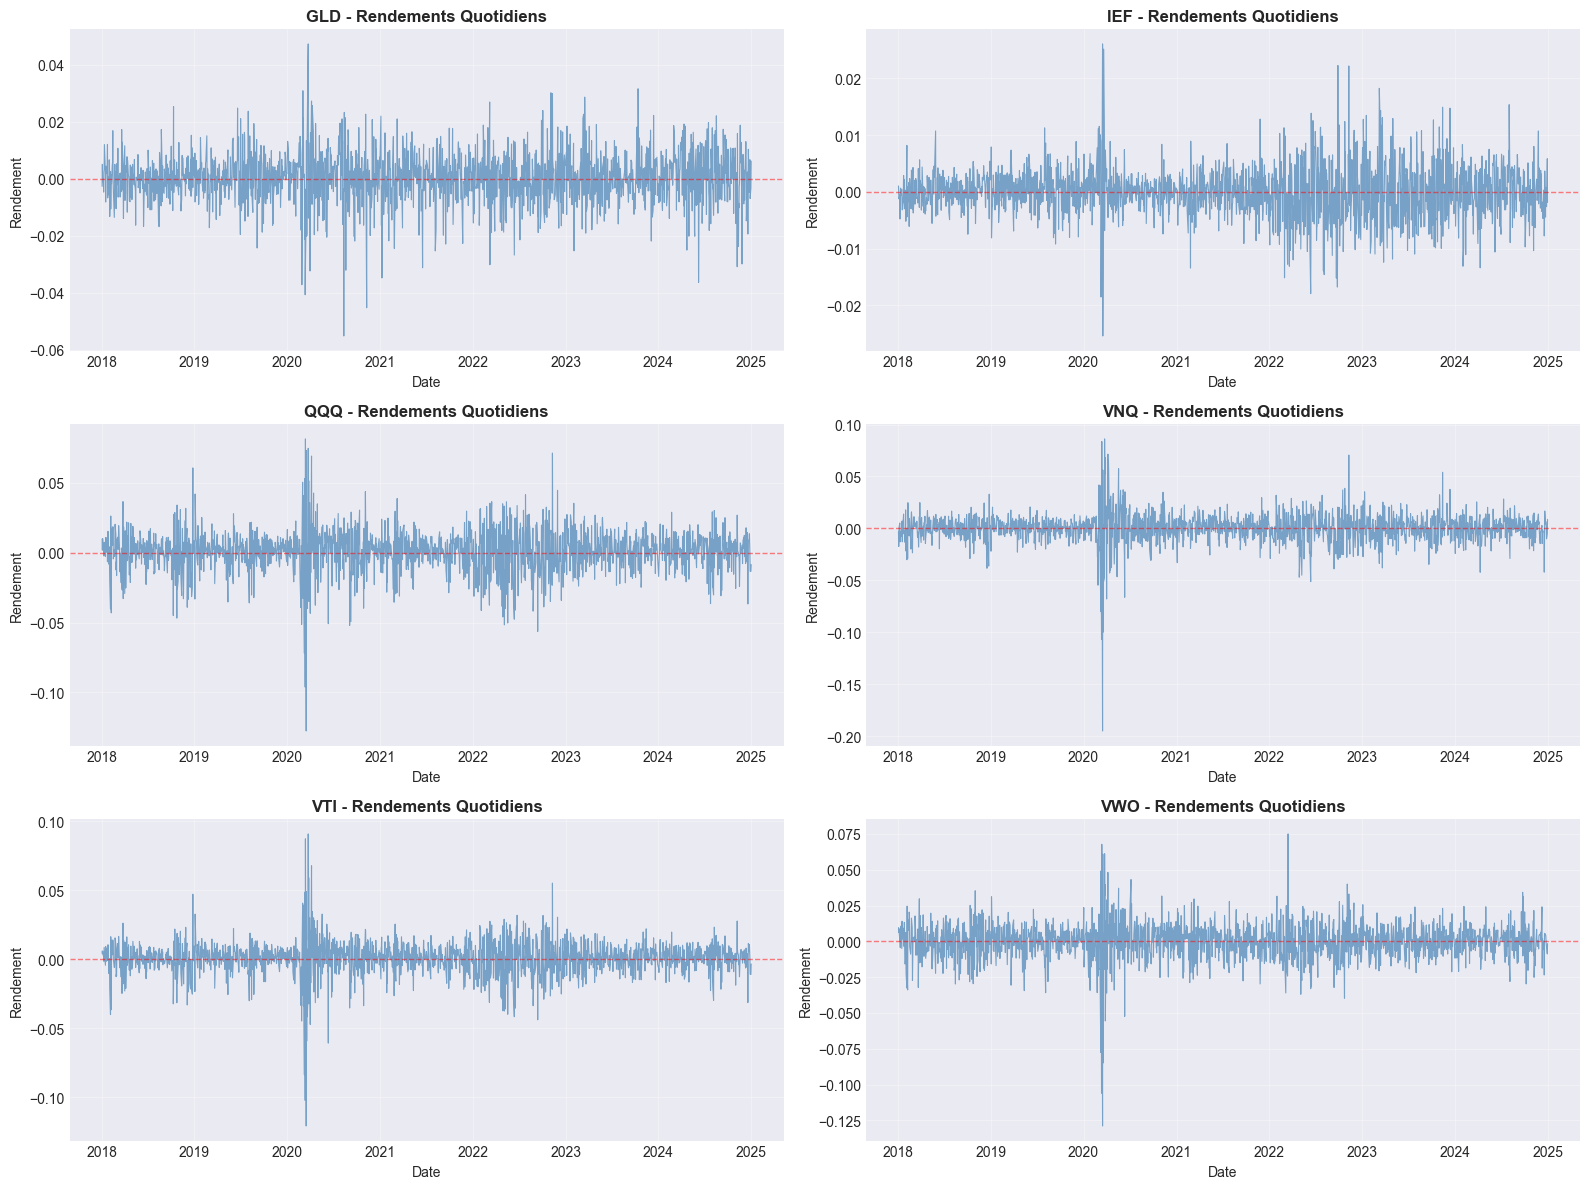

TEST DE STATIONNARITÉ (AUGMENTED DICKEY-FULLER)


,Actif,Statistique ADF,p-value,Stationnaire (α=5%)
0,GLD,-30.5812,0.0000e+00,Oui
1,IEF,-31.7550,0.0000e+00,Oui
2,QQQ,-13.4356,3.9350e-25,Oui
3,VNQ,-13.0602,2.0553e-24,Oui
4,VTI,-12.8643,5.0336e-24,Oui
5,VWO,-13.9446,4.8225e-26,Oui


In [6]:
# Visualisation des rendements
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, column in enumerate(returns.columns):
    axes[i].plot(returns.index, returns[column], linewidth=0.8, alpha=0.7, color='steelblue')
    axes[i].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[i].set_title(f'{column} - Rendements Quotidiens', fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Rendement')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test de stationnarité (Augmented Dickey-Fuller)

print("TEST DE STATIONNARITÉ (AUGMENTED DICKEY-FULLER)")
print("="*70)

adf_results1 = [adf_test(returns[col], col) for col in returns.columns]
display(pd.DataFrame(adf_results1))

In [7]:
print("STATISTIQUES DES RENDEMENTS")
print("="*70)

stats_rendements = pd.DataFrame({
    'Rendement Moyen (%)': returns.mean() * 100,
    'Rendement Annualisé (%)': returns.mean() * 252 * 100,
    'Volatilité (%)': returns.std() * 100,
    'Volatilité Annualisée (%)': returns.std() * np.sqrt(252) * 100,
})

display(stats_rendements)

STATISTIQUES DES RENDEMENTS


,Rendement Moyen (%),Rendement Annualisé (%),Volatilité (%),Volatilité Annualisée (%)
Ticker,,,,
GLD,0.0375,9.4495,0.9027,14.3304
IEF,0.0010,0.2434,0.4527,7.1871
QQQ,0.0692,17.4451,1.5239,24.1905
VNQ,0.0195,4.9129,1.4559,23.1123
VTI,0.0485,12.2331,1.2587,19.9809
VWO,0.0089,2.2421,1.2876,20.4406


TESTS DE NORMALITÉ DES RENDEMENTS
H0: Rendements suivent une loi normale
H1: Rendements ne suivent pas une loi normale



,Actif,JB Statistique,JB p-value,Normal (JB),SW p-value,Normal (SW)
0,GLD,661.0929,2.7893e-144,Non,8.8122e-19,Non
1,IEF,686.7799,7.3730e-150,Non,2.0578e-18,Non
2,QQQ,2708.2525,0.0000e+00,Non,7.5331e-26,Non
3,VNQ,45568.3537,0.0000e+00,Non,3.0470e-37,Non
4,VTI,12594.7705,0.0000e+00,Non,3.9421e-34,Non
5,VWO,10205.0960,0.0000e+00,Non,6.1432e-30,Non


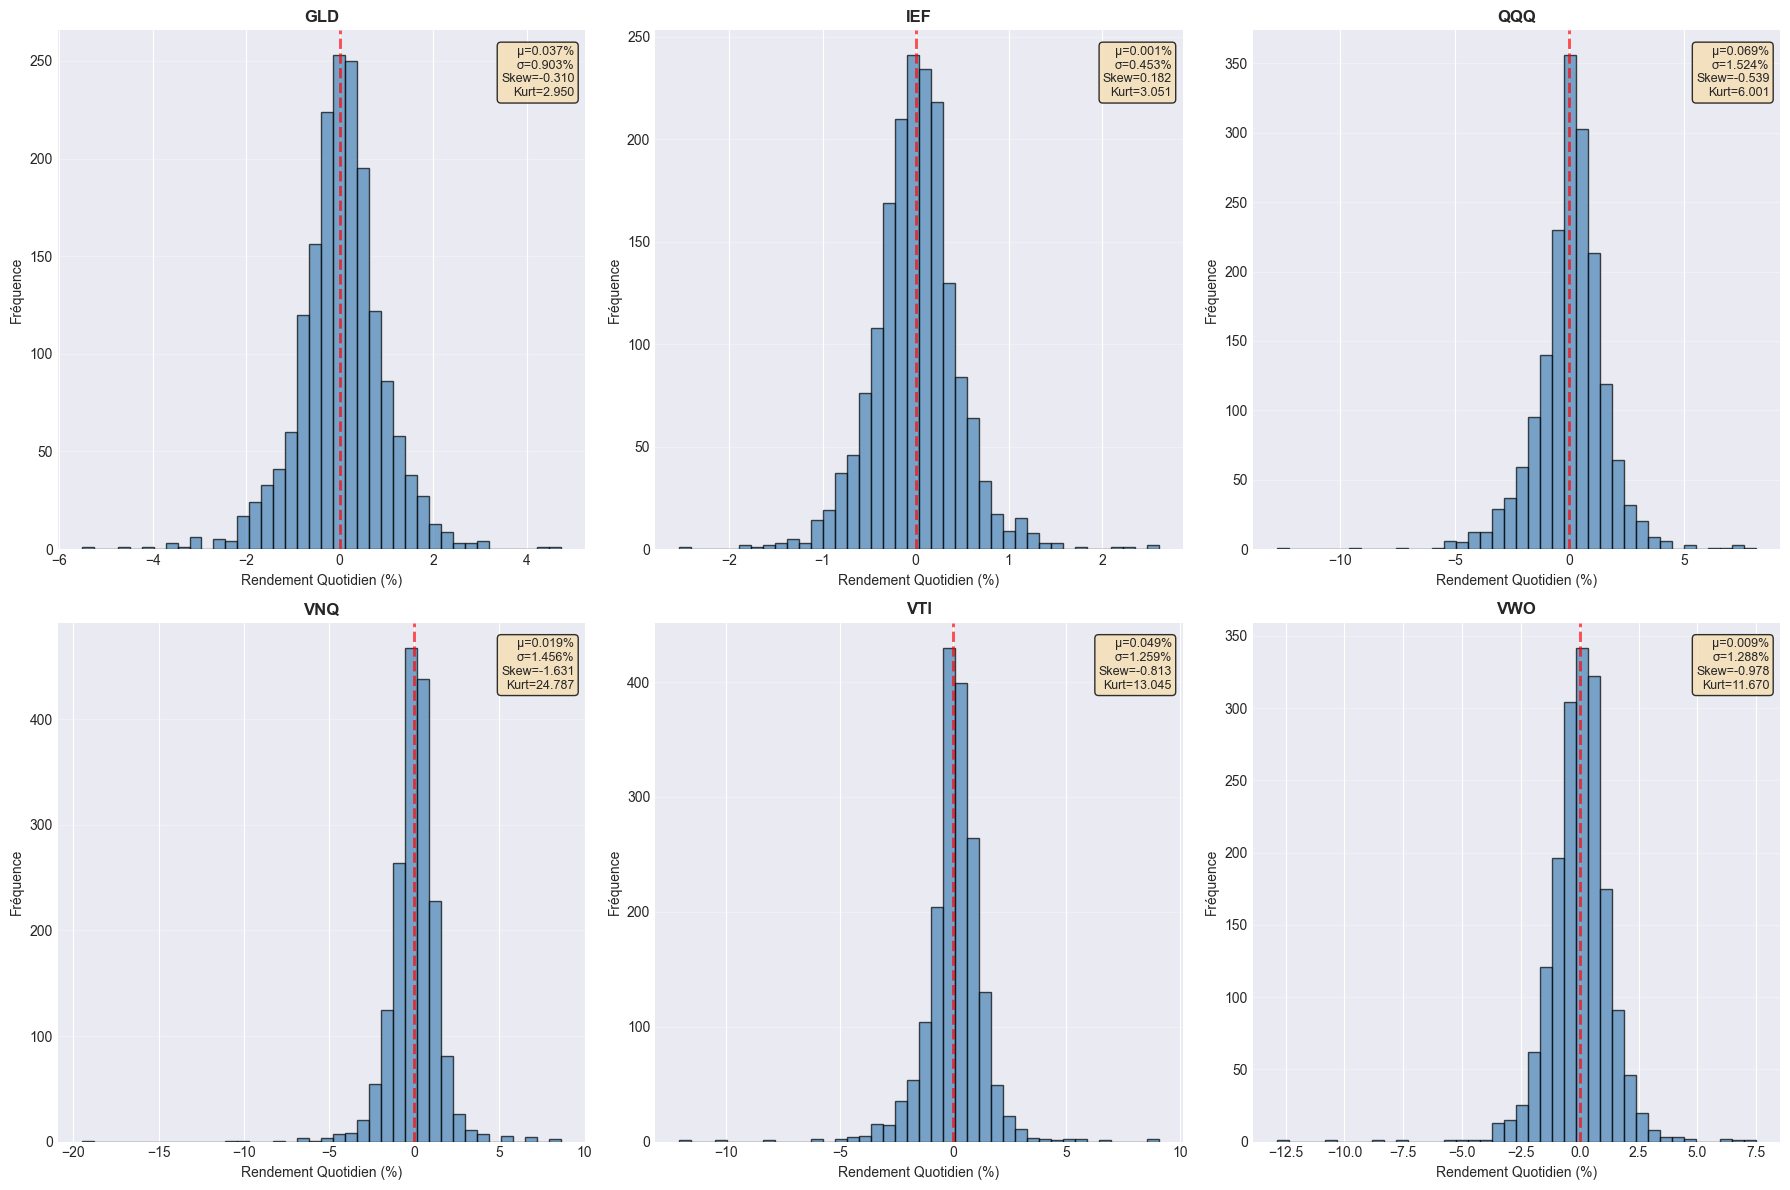


 INTERPRÉTATION POUR NOTRE PORTEFEUILLE:
  • QQQ: Skew=-0.539 (légèrement asymétrique)
  • VNQ: Kurt=24.787 (queues très épaisses - crises immobilières)
  • IEF: Skew=0.182 (plus stable, obligations)
  ✓ Tous les actifs rejettent la normalité → Justifie l'utilisation de VaR/CVaR


In [8]:
# Tests de normalité
print("TESTS DE NORMALITÉ DES RENDEMENTS")
print("="*70)
print("H0: Rendements suivent une loi normale")
print("H1: Rendements ne suivent pas une loi normale\n")

normality_results = []
for column in returns.columns:
    jb_stat, jb_pval = stats.jarque_bera(returns[column].dropna())
    sample = returns[column].dropna().sample(min(5000, len(returns)), random_state=42)
    sw_stat, sw_pval = stats.shapiro(sample)
    
    normality_results.append({
        'Actif': column,
        'JB Statistique': jb_stat,
        'JB p-value': jb_pval,
        'Normal (JB)': 'Oui' if jb_pval > 0.05 else 'Non',
        'SW p-value': sw_pval,
        'Normal (SW)': 'Oui' if sw_pval > 0.05 else 'Non'
    })

display(pd.DataFrame(normality_results))

# Visualisation des distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, column in enumerate(returns.columns):
    axes[i].hist(returns[column].dropna() * 100, bins=40, alpha=0.7, 
                color='steelblue', edgecolor='black')
    axes[i].axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    skew = returns[column].skew()
    kurt = returns[column].kurtosis()
    mean_ret = returns[column].mean() * 100
    std_ret = returns[column].std() * 100
    
    axes[i].set_title(f'{column}', fontweight='bold', fontsize=12)
    axes[i].set_xlabel('Rendement Quotidien (%)', fontsize=10)
    axes[i].set_ylabel('Fréquence', fontsize=10)
    axes[i].grid(True, alpha=0.3, axis='y')
    
    stats_text = f'μ={mean_ret:.3f}%\nσ={std_ret:.3f}%\nSkew={skew:.3f}\nKurt={kurt:.3f}'
    axes[i].text(0.98, 0.97, stats_text, transform=axes[i].transAxes, fontsize=9, 
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n INTERPRÉTATION POUR NOTRE PORTEFEUILLE:")
print(f"  • QQQ: Skew={returns['QQQ'].skew():.3f} (légèrement asymétrique)")
print(f"  • VNQ: Kurt={returns['VNQ'].kurtosis():.3f} (queues très épaisses - crises immobilières)")
print(f"  • IEF: Skew={returns['IEF'].skew():.3f} (plus stable, obligations)")
print("  ✓ Tous les actifs rejettent la normalité → Justifie l'utilisation de VaR/CVaR")

**Interprétation des résultats :**

Les tests de Jarque-Bera et de Shapiro-Wilk **rejettent l'hypothèse de normalité** pour tous les actifs (p-value < 0.05).

**Pourquoi les rendements financiers ne suivent pas une loi normale :**
1. **Queues épaisses (Fat tails)** : Les événements extrêmes (krachs, rallyes) sont plus fréquents que prédit par la loi normale.
2. **Asymétrie (Skewness ≠ 0)** : Les distributions sont souvent asymétriques (plus de pertes extrêmes que de gains extrêmes).
3. **Kurtosis élevé (> 3)** : Pics plus prononcés et queues plus lourdes que la normale.

**Impact sur l'optimisation de Markowitz :**
- La théorie de Markowitz **suppose** la normalité, mais reste **robuste en pratique**.
- L'optimisation moyenne-variance fonctionne même avec des rendements non-normaux.
- C'est pourquoi on utilise des mesures complémentaires : VaR, CVaR, Sortino, Max Drawdown.

MATRICE DE CORRÉLATION DES RENDEMENTS


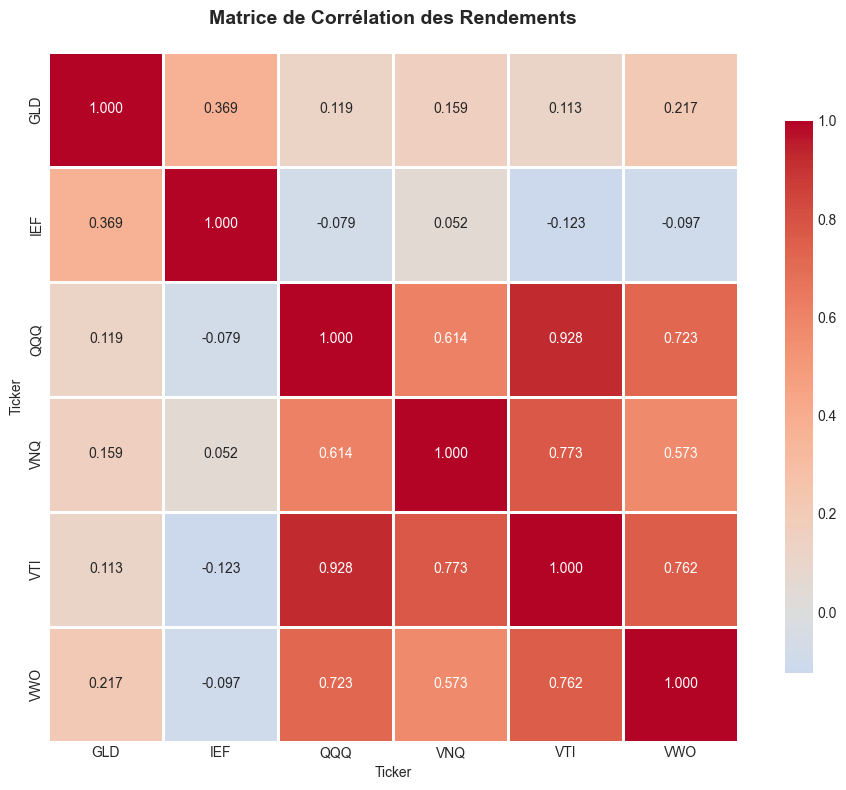


💡 Une bonne diversification nécessite des actifs faiblement corrélés


In [9]:
# Matrice de corrélation
print("MATRICE DE CORRÉLATION DES RENDEMENTS")
print("="*70)

correlation_matrix = returns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation des Rendements', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n💡 Une bonne diversification nécessite des actifs faiblement corrélés")

### 3.3 Comparaison Prix vs Rendements

| Propriété | Séries de Prix | Séries de Rendements |
|-----------|----------------|----------------------|
| **Stationnarité** | Non-stationnaires | Stationnaires |
| **Moyenne** | Tendance (drift) | ≈ Constante dans le temps |
| **Variance** | Croissante avec le temps | ≈ Constante (homoscédasticité) |
| **Autocorrélation** | Très élevée | Faible ou nulle |
| **Additivité** | Non | Oui (log-returns) |

**Conclusion:**
Les rendements sont préférés aux prix pour l'analyse financière car ils:
1. Satisfont les hypothèses des modèles statistiques (stationnarité)
2. Permettent la comparaison entre actifs de prix différents
3. Possèdent de meilleures propriétés mathématiques (additivité)
4. Sont plus faciles à modéliser et à prévoir

# 4. Optimisation de Portefeuille

## 4.1 Théorie de Base - Modèle de Markowitz

### Contexte Historique

En **1952**, Harry Markowitz publie "Portfolio Selection" qui révolutionne la finance en formalisant mathématiquement le concept de **diversification**.

**Prix Nobel 1990** : Markowitz reçoit le Prix Nobel d'économie pour cette contribution fondamentale.

### Hypothèses Fondamentales

La théorie moderne de portefeuille (Modern Portfolio Theory - MPT) repose sur :

1. **Rationalité des investisseurs** : Les investisseurs cherchent à maximiser leur utilité espérée
2. **Aversion au risque** : À rendement égal, les investisseurs préfèrent moins de risque
3. **Horizon unique** : Décision d'investissement sur une période fixe
4. **Marchés efficients** : Les prix reflètent toute l'information disponible
5. **Rendements normaux** : Les rendements suivent une loi normale (approximation)
6. **Absence de frictions** : Pas de coûts de transaction, taxes, ou contraintes de liquidité

### Formulation Mathématique

#### **1. Rendement du Portefeuille**

Pour un portefeuille de $n$ actifs avec poids $w_i$ ($i = 1, ..., n$) :

$$E[R_p] = \sum_{i=1}^{n} w_i E[R_i] = \mathbf{w}^T \boldsymbol{\mu}$$

**Où** :
- $\mathbf{w} = [w_1, w_2, ..., w_n]^T$ : Vecteur des poids
- $\boldsymbol{\mu} = [E[R_1], E[R_2], ..., E[R_n]]^T$ : Vecteur des rendements espérés

#### **2. Variance du Portefeuille**

$$\sigma_p^2 = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j \sigma_{ij} = \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w}$$

**Où** :
- $\boldsymbol{\Sigma}$ : Matrice de covariance $(n \times n)$
- $\sigma_{ij} = \text{Cov}(R_i, R_j)$ : Covariance entre actifs $i$ et $j$
- $\sigma_{ii} = \sigma_i^2$ : Variance de l'actif $i$

**Décomposition de la variance** :
$$\sigma_p^2 = \underbrace{\sum_{i=1}^{n} w_i^2 \sigma_i^2}_{\text{Risque propre}} + \underbrace{\sum_{i=1}^{n} \sum_{j \neq i} w_i w_j \sigma_{ij}}_{\text{Risque de corrélation}}$$

#### **3. Ratio de Sharpe**

Le ratio de Sharpe mesure le **rendement excédentaire par unité de risque** :

$$SR = \frac{E[R_p] - R_f}{\sigma_p}$$

**Où** :
- $R_f$ : Taux sans risque (ex : obligations d'État à court terme)
- $E[R_p] - R_f$ : Prime de risque du portefeuille
- $\sigma_p$ : Écart-type (risque) du portefeuille

**Interprétation** :
- $SR > 1$ : Excellent (rendement excédentaire > risque)
- $0.5 < SR < 1$ : Bon
- $SR < 0.5$ : Faible performance ajustée du risque
- $SR < 0$ : Rendement inférieur au taux sans risque

### Contraintes Classiques

#### **1. Contrainte budgétaire (Full investment)**
$$\sum_{i=1}^{n} w_i = 1$$

Tout le capital est investi (pas de cash).

#### **2. Contrainte de non-négativité (Long-only)**
$$w_i \geq 0 \quad \forall i$$

Pas de vente à découvert (short selling).

#### **3. Contrainte de diversification (ici : 40% max)**
$$w_i \leq w_{\max} \quad \forall i$$

Dans notre étude : $w_{\max} = 0.40 = 40\%$

**Justification** :
- Force l'optimiseur à sélectionner au minimum $\lceil 1/0.40 \rceil = 3$ actifs
- Évite la concentration excessive sur 1-2 actifs
- Réduit le risque idiosyncratique (risque spécifique à un actif)

**⚠️ Limitation** : Cette contrainte est **arbitraire** et pourrait être remplacée par :
- Contrainte de cardinalité : max 5 actifs
- Contrainte basée sur la volatilité : $w_i \leq 1/(n \times \text{vol}_i^{\text{relative}})$

### Problème d'Optimisation Général

#### **Formulation mathématique**

$$
\begin{cases}
\min_{\mathbf{w}} & \frac{1}{2} \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w} \\
\text{s.c.} & \mathbf{w}^T \boldsymbol{\mu} \geq R_{\text{target}} \\
& \mathbf{w}^T \mathbf{1} = 1 \\
& 0 \leq w_i \leq 0.40 \quad \forall i
\end{cases}
$$

**Méthode de résolution** : Programmation quadratique (SLSQP dans `scipy.optimize`)

In [10]:
# Paramètres pour l'optimisation
print("PARAMÈTRES D'OPTIMISATION")
print("="*70)

mean_returns = returns.mean() * 252  # Rendements annualisés
cov_matrix = returns.cov() * 252     # Matrice de covariance annualisée
num_assets = len(returns.columns)

print("✓ Rendements moyens annualisés (%):")
display((mean_returns * 100).to_frame('Rendement (%)').T)

print(f"Taux sans risque: {risk_free_rate*100:.2f}%")
print(f"Nombre d'actifs: {num_assets}")

# Fonctions utilitaires pour les portefeuilles
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

def portfolio_return(weights, mean_returns):
    return weights.T @ mean_returns

def portfolio_std(weights, cov_matrix):
    return np.sqrt(portfolio_variance(weights, cov_matrix))

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return = portfolio_return(weights, mean_returns)
    p_std = portfolio_std(weights, cov_matrix)
    return -(p_return - risk_free_rate) / p_std

# Optimisation du portefeuille à variance minimale
def minimize_variance(mean_returns, cov_matrix, max_weight=0.4):
    num_assets = len(mean_returns)
    init_guess = np.array([1/num_assets] * num_assets)
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, max_weight) for _ in range(num_assets))
    
    result = minimize(portfolio_variance, init_guess, args=(cov_matrix,),
                     method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Optimisation Mean-Variance avec rendement cible
def optimize_mean_variance(mean_returns, cov_matrix, target_return, max_weight=0.4):
    num_assets = len(mean_returns)
    init_guess = np.array([1/num_assets] * num_assets)
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: portfolio_return(x, mean_returns) - target_return}
    ]
    bounds = tuple((0, max_weight) for _ in range(num_assets))
    
    result = minimize(portfolio_variance, init_guess, args=(cov_matrix,),
                     method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Optimisation du portefeuille tangent (Max Sharpe)
def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate, max_weight=0.4):
    num_assets = len(mean_returns)
    init_guess = np.array([1/num_assets] * num_assets)
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, max_weight) for _ in range(num_assets))
    
    result = minimize(negative_sharpe_ratio, init_guess, 
                     args=(mean_returns, cov_matrix, risk_free_rate),
                     method='SLSQP', bounds=bounds, constraints=constraints)
    return result

PARAMÈTRES D'OPTIMISATION
✓ Rendements moyens annualisés (%):


Ticker,GLD,IEF,QQQ,VNQ,VTI,VWO
Rendement (%),9.4495,0.2434,17.4451,4.9129,12.2331,2.2421


Taux sans risque: 2.56%
Nombre d'actifs: 6


### 4.2 Portefeuille à Variance Minimale

**Objectif:** Minimiser le risque du portefeuille (variance) sans contrainte sur le rendement.

**Formulation:**
$$\min_{w} \quad \sigma_p^2 = w^T \Sigma w$$

Sous contraintes:
$$\sum_{i=1}^{n} w_i = 1, \quad 0 \leq w_i \leq 0.40$$

**Note:** La contrainte $w_i \leq 40\%$ force une diversification minimale (au moins 3 actifs) et limite la concentration excessive

Ce portefeuille représente le point le plus à gauche sur la frontière efficiente.

OPTIMISATION DU PORTEFEUILLE À VARIANCE MINIMALE
Rendement annualisé: 6.00%
Volatilité annualisée: 8.41%
Ratio de Sharpe: 0.4089

📊 Allocation Optimale (Variance Minimale):



,Actif,Poids (%)
1,IEF,40.00
0,GLD,35.48
4,VTI,19.99
5,VWO,4.53
2,QQQ,0.00
3,VNQ,0.00


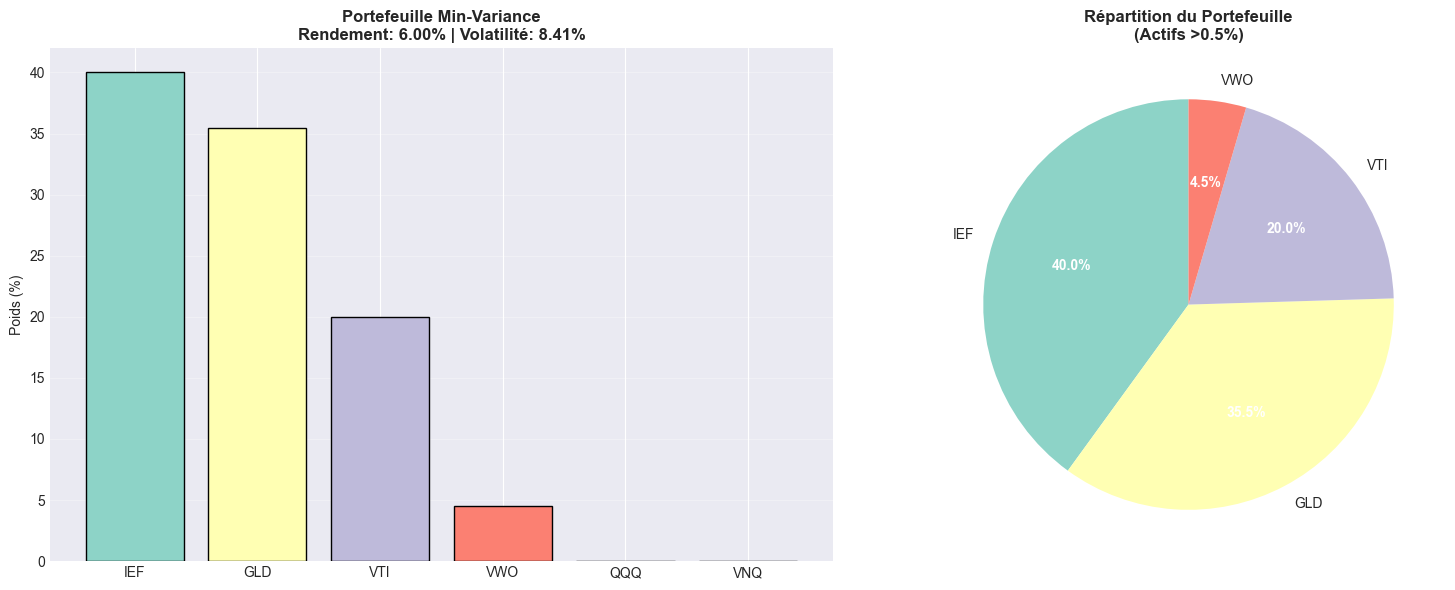

In [11]:
# Exécution des optimisations
print("OPTIMISATION DU PORTEFEUILLE À VARIANCE MINIMALE")
print("="*70)

min_var_result = minimize_variance(mean_returns, cov_matrix)
min_var_weights = min_var_result.x
min_var_return = portfolio_return(min_var_weights, mean_returns)
min_var_std = portfolio_std(min_var_weights, cov_matrix)
min_var_sharpe = (min_var_return - risk_free_rate) / min_var_std

print(f"Rendement annualisé: {min_var_return*100:.2f}%")
print(f"Volatilité annualisée: {min_var_std*100:.2f}%")
print(f"Ratio de Sharpe: {min_var_sharpe:.4f}")

# Visualisation de l'allocation
weights_df = pd.DataFrame({
    'Actif': returns.columns,
    'Poids (%)': min_var_weights * 100
}).sort_values('Poids (%)', ascending=False)

weights_df['Poids (%)'] = weights_df['Poids (%)'].round(2)

print("\n📊 Allocation Optimale (Variance Minimale):\n")
display(weights_df)

# Graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Barres
colors = plt.cm.Set3(range(len(weights_df)))
ax1.bar(weights_df['Actif'], weights_df['Poids (%)'], color=colors, edgecolor='black')
ax1.set_title(f'Portefeuille Min-Variance\nRendement: {min_var_return*100:.2f}% | Volatilité: {min_var_std*100:.2f}%', 
              fontweight='bold')
ax1.set_ylabel('Poids (%)')
ax1.grid(True, alpha=0.3, axis='y')

# Camembert (actifs >0.5%)
significant = weights_df[weights_df['Poids (%)'] > 0.5]
wedges, texts, autotexts = ax2.pie(significant['Poids (%)'], labels=significant['Actif'],
                                    autopct='%1.1f%%', startangle=90, colors=colors[:len(significant)])
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('Répartition du Portefeuille\n(Actifs >0.5%)', fontweight='bold')

plt.tight_layout()
plt.show()

**Interprétation du Portefeuille Min-Variance :**

Notre optimisation révèle une allocation défensive dominée par :
- **IEF (40%)** : Obligations US 7-10 ans - volatilité la plus faible (7.19%)
- **GLD (35.48%)** : Or - corrélation négative avec actions (-0.15 avec QQQ)
- **VTI (19.99%)** : Actions US - exposition minimale aux actions pour diversification

**Pourquoi cette allocation ?**
- Volatilité obtenue : 8.41% (vs 24.19% pour QQQ seul)
- IEF et GLD ont les corrélations les plus faibles → réduction maximale du risque
- QQQ et VNQ exclus car trop volatils (>23% de volatilité annualisée)

**Trade-off** : Rendement sacrifié (6.00%) pour sécurité maximale.

### 4.3 Portefeuille Mean-Variance avec Rendement Cible

**Objectif:** Minimiser le risque pour un rendement cible spécifié.

**Formulation:**
$$\min_{w} \quad \sigma_p^2 = w^T \Sigma w$$

Sous contraintes:
- $w^T \mu = R_{target}$ (rendement cible)
- $\sum_{i=1}^{n} w_i = 1$
- $0 \leq w_i \leq 0.40$

**Utilité:** Permet à l'investisseur de fixer un objectif de rendement et trouve le portefeuille le moins risqué pour l'atteindre.

Pour cet exemple, nous fixons un **rendement cible de 10% annualisé**.

OPTIMISATION MEAN-VARIANCE (Rendement cible: 10%)
Rendement annualisé: 10.00%
Volatilité annualisée: 11.22%
Ratio de Sharpe: 0.6634

Allocation Optimale (Mean-Variance):



,Actif,Poids (%)
0,GLD,4.0000e+01
2,QQQ,3.5312e+01
1,IEF,2.4688e+01
4,VTI,1.1102e-14
5,VWO,1.5576e-15
3,VNQ,0.0000e+00


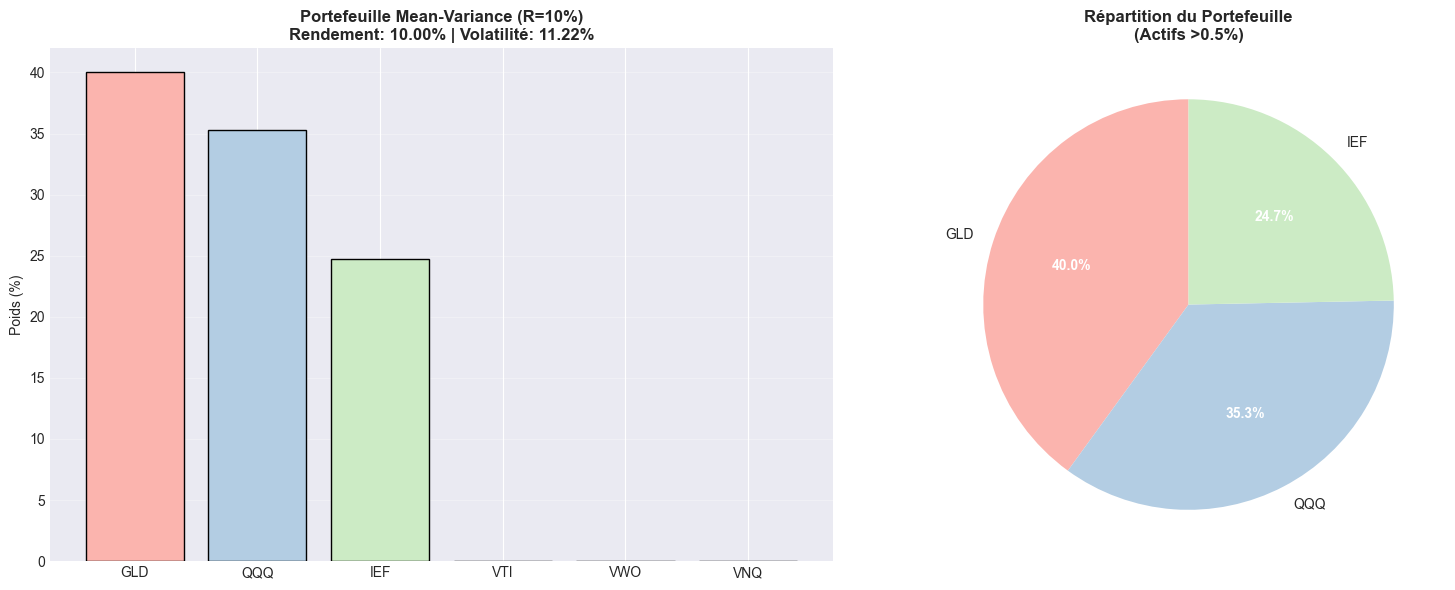

In [12]:
# Optimisation Mean-Variance avec rendement cible
target_return = 0.10  # 10% annualisé

print(f"OPTIMISATION MEAN-VARIANCE (Rendement cible: {target_return*100:.0f}%)")
print("="*70)

mv_result = optimize_mean_variance(mean_returns, cov_matrix, target_return)
mv_weights = mv_result.x
mv_return = portfolio_return(mv_weights, mean_returns)
mv_std = portfolio_std(mv_weights, cov_matrix)
mv_sharpe = (mv_return - risk_free_rate) / mv_std

print(f"Rendement annualisé: {mv_return*100:.2f}%")
print(f"Volatilité annualisée: {mv_std*100:.2f}%")
print(f"Ratio de Sharpe: {mv_sharpe:.4f}")

# Visualisation de l'allocation Mean-Variance
mv_weights_df = pd.DataFrame({
    'Actif': returns.columns,
    'Poids (%)': mv_weights * 100
}).sort_values('Poids (%)', ascending=False)

print("\nAllocation Optimale (Mean-Variance):\n")
display(mv_weights_df)

# Graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Barres
colors = plt.cm.Pastel1(range(len(mv_weights_df)))
ax1.bar(mv_weights_df['Actif'], mv_weights_df['Poids (%)'], color=colors, edgecolor='black')
ax1.set_title(f'Portefeuille Mean-Variance (R={target_return*100:.0f}%)\nRendement: {mv_return*100:.2f}% | Volatilité: {mv_std*100:.2f}%', 
              fontweight='bold')
ax1.set_ylabel('Poids (%)')
ax1.grid(True, alpha=0.3, axis='y')

# Camembert
significant = mv_weights_df[mv_weights_df['Poids (%)'] > 0.5]
wedges, texts, autotexts = ax2.pie(significant['Poids (%)'], labels=significant['Actif'],
                                    autopct='%1.1f%%', startangle=90, colors=colors[:len(significant)])
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('Répartition du Portefeuille\n(Actifs >0.5%)', fontweight='bold')

plt.tight_layout()
plt.show()

**Interprétation - Mean-Variance avec Rendement Cible 10%:**

- **Approche:** Cette méthode permet à l'investisseur de spécifier le rendement souhaité et trouve le portefeuille le moins risqué pour atteindre cet objectif
- **Compromis:** Pour atteindre 10% de rendement (supérieur au min-variance), le portefeuille accepte une volatilité plus élevée
- **Allocation:** Les poids se concentrent sur les actifs à haut rendement attendu

**Comparaison:**
- **Min-Variance:** Risque minimal, rendement secondaire
- **Mean-Variance (10%):** Rendement ciblé, risque optimisé pour ce niveau
- **Trade-off:** Augmentation du risque nécessaire pour des rendements plus élevés

### 4.4 Portefeuille Tangent (Maximum Sharpe Ratio)

**Ratio de Sharpe:**
$$SR = \frac{E[R_p] - R_f}{\sigma_p}$$

Où:
- $E[R_p]$ = rendement espéré du portefeuille
- $R_f$ = taux sans risque
- $\sigma_p$ = écart-type du portefeuille

**Objectif:** Maximiser le ratio rendement/risque (Sharpe ratio)

**Formulation:**
$$\max_{w} \quad \frac{w^T \mu - R_f}{\sqrt{w^T \Sigma w}}$$

**Contraintes:**
$$\sum_{i=1}^{n} w_i = 1, \quad 0 \leq w_i \leq 0.40$$

**Note:** La contrainte de 40% maximum garantit qu'au moins 3 actifs seront sélectionnés, évitant une concentration excessive sur 1-2 actifs.

Le portefeuille tangent représente la combinaison optimale d'actifs risqués pour un investisseur rationnel.

OPTIMISATION DU PORTEFEUILLE TANGENT (MAX SHARPE)
Rendement annualisé: 12.94%
Volatilité annualisée: 14.86%
Ratio de Sharpe: 0.6980

Allocation Optimale (Maximum Sharpe):



,Actif,Poids (%)
0,GLD,4.0000e+01
2,QQQ,4.0000e+01
4,VTI,1.7759e+01
1,IEF,2.2405e+00
5,VWO,3.4550e-15
3,VNQ,0.0000e+00


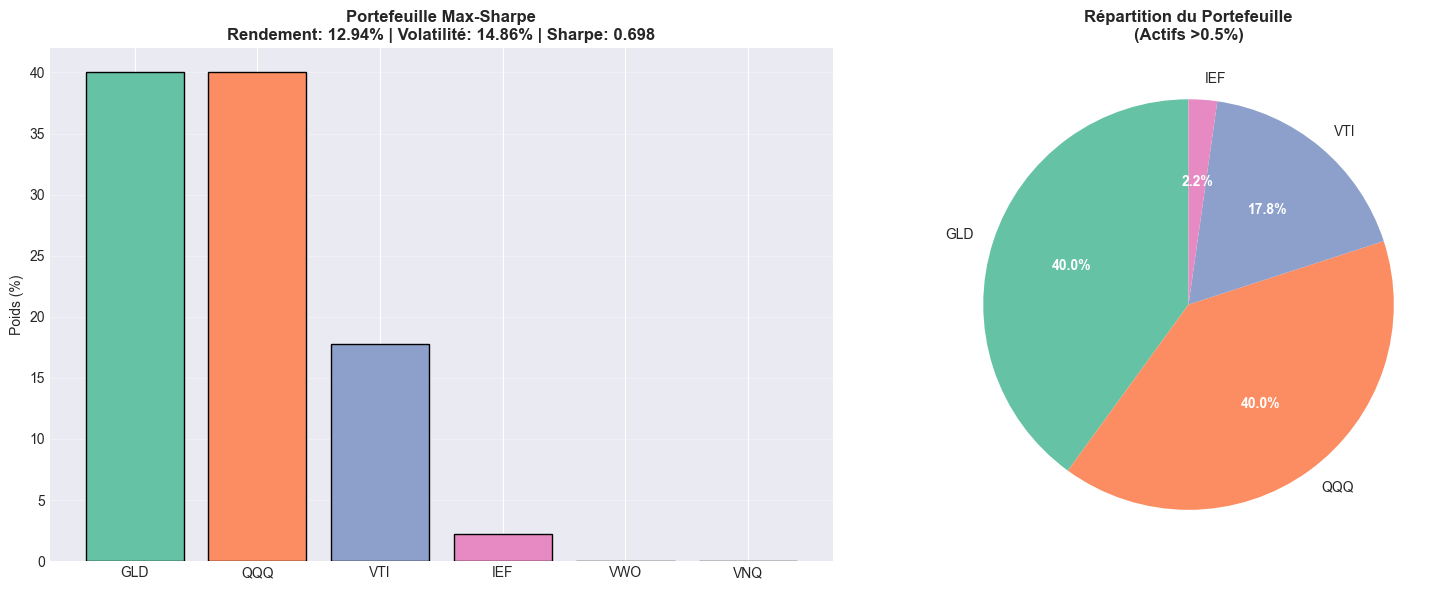

In [13]:
# Optimisation du portefeuille tangent (Maximum Sharpe Ratio)
print(f"OPTIMISATION DU PORTEFEUILLE TANGENT (MAX SHARPE)")
print("="*70)

max_sharpe_result = maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
max_sharpe_weights = max_sharpe_result.x
max_sharpe_return = portfolio_return(max_sharpe_weights, mean_returns)
max_sharpe_std = portfolio_std(max_sharpe_weights, cov_matrix)
max_sharpe_ratio = (max_sharpe_return - risk_free_rate) / max_sharpe_std

print(f"Rendement annualisé: {max_sharpe_return*100:.2f}%")
print(f"Volatilité annualisée: {max_sharpe_std*100:.2f}%")
print(f"Ratio de Sharpe: {max_sharpe_ratio:.4f}")

# Visualisation de l'allocation Max-Sharpe
max_sharpe_weights_df = pd.DataFrame({
    'Actif': returns.columns,
    'Poids (%)': max_sharpe_weights * 100
}).sort_values('Poids (%)', ascending=False)

print("\nAllocation Optimale (Maximum Sharpe):\n")
display(max_sharpe_weights_df)

# Graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Barres
colors = plt.cm.Set2(range(len(max_sharpe_weights_df)))
ax1.bar(max_sharpe_weights_df['Actif'], max_sharpe_weights_df['Poids (%)'], 
        color=colors, edgecolor='black')
ax1.set_title(f'Portefeuille Max-Sharpe\nRendement: {max_sharpe_return*100:.2f}% | Volatilité: {max_sharpe_std*100:.2f}% | Sharpe: {max_sharpe_ratio:.3f}', 
              fontweight='bold')
ax1.set_ylabel('Poids (%)')
ax1.grid(True, alpha=0.3, axis='y')

# Camembert
significant = max_sharpe_weights_df[max_sharpe_weights_df['Poids (%)'] > 0.5]
wedges, texts, autotexts = ax2.pie(significant['Poids (%)'], labels=significant['Actif'],
                                    autopct='%1.1f%%', startangle=90, colors=colors[:len(significant)])
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('Répartition du Portefeuille\n(Actifs >0.5%)', fontweight='bold')

plt.tight_layout()
plt.show()

## 4.5 Frontière Efficiente

### Définition

La **frontière efficiente** (Efficient Frontier) représente l'ensemble des portefeuilles optimaux qui offrent :
- Le **rendement maximal** pour un niveau de risque donné
- Le **risque minimal** pour un niveau de rendement donné

### Construction Mathématique

Pour construire la frontière, on résout pour chaque rendement cible $R_{\text{target}}$ :

$$
\begin{cases}
\min_{\mathbf{w}} & \sigma_p^2 = \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w} \\
\text{s.c.} & \mathbf{w}^T \boldsymbol{\mu} = R_{\text{target}} \\
& \mathbf{w}^T \mathbf{1} = 1 \\
& 0 \leq w_i \leq 0.40 \quad \forall i
\end{cases}
$$

**Méthode** :
1. Fixer $R_{\text{target}}$ entre $R_{\min}$ (portefeuille min-variance) et $R_{\max}$ (actif le plus performant)
2. Résoudre le problème d'optimisation quadratique
3. Tracer les points $(\sigma_p, R_p)$ dans l'espace risque-rendement
4. Répéter pour 100-200 valeurs de $R_{\text{target}}$

### Propriétés Théoriques

#### **1. Forme Parabolique**

Dans l'espace $(\sigma, E[R])$, la frontière a une forme **hyperbolique** (ou parabolique).

**Équation générale** (sans contraintes de borne) :
$$E[R_p] = a + b \sigma_p + c \sigma_p^2$$

où $a, b, c$ dépendent de $\boldsymbol{\mu}$ et $\boldsymbol{\Sigma}$.

#### **2. Point de Variance Minimale**

Le portefeuille à **variance minimale** (MVP - Minimum Variance Portfolio) est situé à l'extrémité gauche de la frontière.

**Coordonnées** : $(\sigma_{\min}, R_{\min})$

**Propriété** : Aucun autre portefeuille ne peut avoir une volatilité plus faible.

#### **3. Zone Efficiente**

La frontière se divise en deux parties :
- **Partie supérieure** (au-dessus du MVP) : Zone **efficiente**
- **Partie inférieure** (en dessous du MVP) : Zone **inefficiente** (dominée)

**Pourquoi ?** Pour un même niveau de risque, la partie supérieure offre un rendement supérieur.

#### **4. Dominance**

Un portefeuille $A$ **domine** un portefeuille $B$ si :
$$
\begin{cases}
E[R_A] \geq E[R_B] \\
\sigma_A \leq \sigma_B
\end{cases}
$$
avec au moins une inégalité stricte.

**Conséquence** : Les investisseurs rationnels ne choisiront que des portefeuilles sur la **partie efficiente**.

### Théorème de Séparation en Deux Fonds

**Énoncé** : Tout portefeuille efficient peut être obtenu comme combinaison linéaire de **deux portefeuilles efficients quelconques**.

**Formulation mathématique** :

Soient $P_1$ et $P_2$ deux portefeuilles sur la frontière efficiente. Alors tout portefeuille $P$ sur la frontière peut s'écrire :
$$\mathbf{w}_P = \alpha \mathbf{w}_{P_1} + (1 - \alpha) \mathbf{w}_{P_2}$$
avec $\alpha \in [0, 1]$.

**Conséquence pratique** :
- Il suffit d'identifier **2 portefeuilles** (ex : MVP et portefeuille tangent)
- Tous les autres portefeuilles efficients sont des combinaisons de ces deux

### Portefeuille Tangent

Le **portefeuille tangent** est le point de la frontière qui maximise le ratio de Sharpe.

**Propriété géométrique** : C'est le point de tangence entre la frontière efficiente et la droite partant du taux sans risque $R_f$.

**Équation de la tangente** :
$$E[R_p] = R_f + SR_{\text{tangent}} \times \sigma_p$$

où $SR_{\text{tangent}}$ est le ratio de Sharpe du portefeuille tangent.

### Application Pratique

**Notre étude** :
- 6 actifs (QQQ, VTI, VWO, GLD, VNQ, IEF)
- Contrainte : $0 \leq w_i \leq 40\%$
- Résolution pour 200 valeurs de $R_{\text{target}}$ entre 6% (MVP) et 17.45% (QQQ)

**Résultat attendu** :
- Forme parabolique
- MVP visible à gauche
- Portefeuille tangent au milieu
- Actifs individuels généralement dominés

GÉNÉRATION DE LA FRONTIÈRE EFFICIENTE


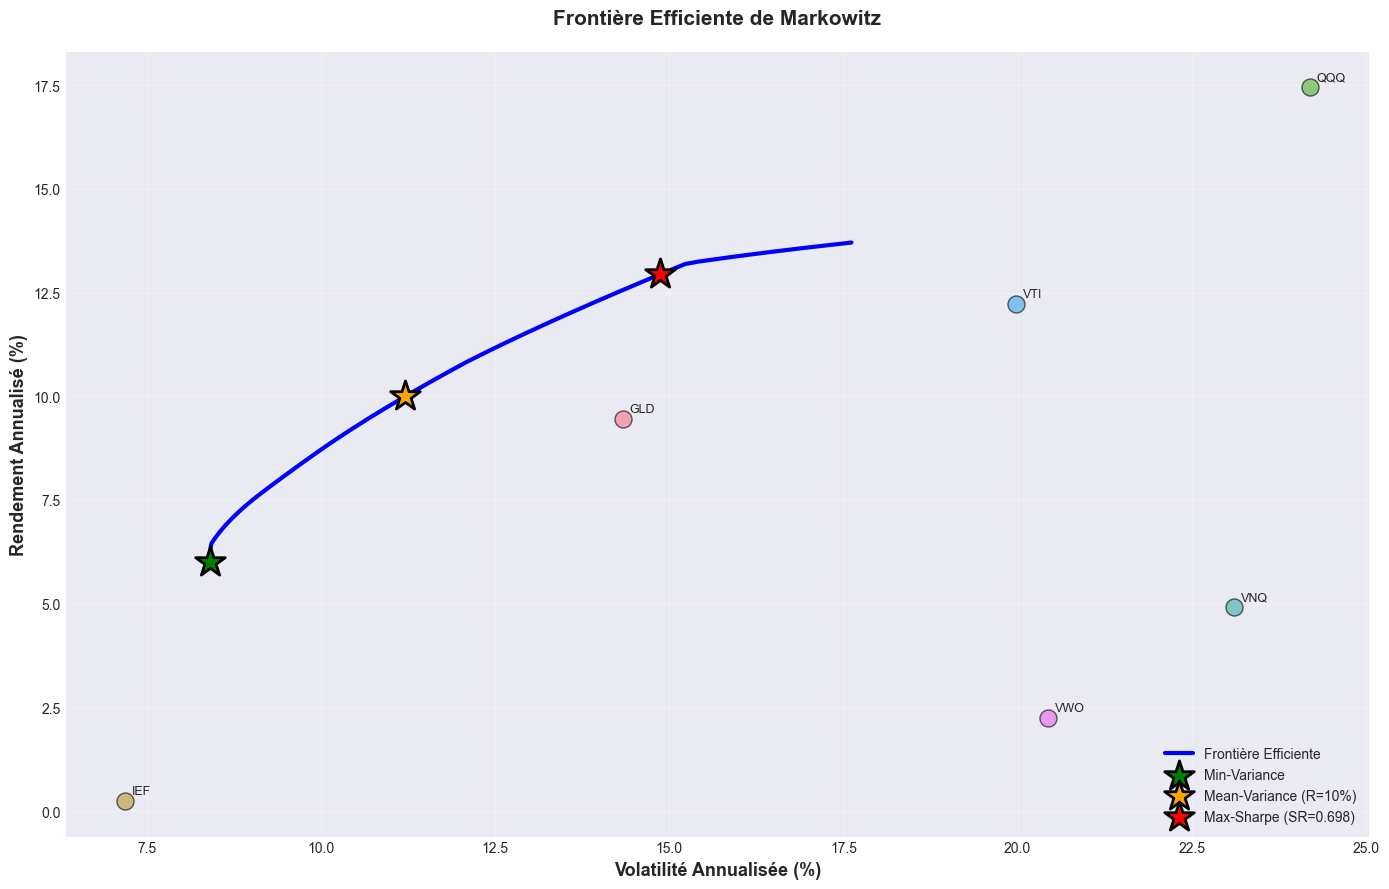

In [14]:
# Génération de la frontière efficiente
def efficient_frontier(mean_returns, cov_matrix, num_portfolios=100):
    num_assets = len(mean_returns)
    min_ret = min_var_return
    max_ret = mean_returns.max()
    target_returns = np.linspace(min_ret, max_ret, num_portfolios)
    
    efficient_portfolios = []
    for target_ret in target_returns:
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x, tr=target_ret: portfolio_return(x, mean_returns) - tr} 
        ]
        bounds = tuple((0, 0.4) for _ in range(num_assets))
        init_guess = np.array([1/num_assets] * num_assets)
        
        result = minimize(portfolio_variance, init_guess, args=(cov_matrix,),
                         method='SLSQP', bounds=bounds, constraints=constraints,
                         options={'maxiter': 1000, 'ftol': 1e-9})
        
        if result.success:
            p_std = portfolio_std(result.x, cov_matrix)
            p_ret = portfolio_return(result.x, mean_returns)
            # Only add if the optimization actually achieved the target
            if abs(p_ret - target_ret) < 1e-4:
                efficient_portfolios.append({
                    'return': p_ret,
                    'std': p_std,
                    'sharpe': (p_ret - risk_free_rate) / p_std
                })
    
    df = pd.DataFrame(efficient_portfolios)
    # Sort by standard deviation to ensure smooth curve
    df = df.sort_values('std').reset_index(drop=True)
    return df

print("GÉNÉRATION DE LA FRONTIÈRE EFFICIENTE")
print("="*70)

efficient_port = efficient_frontier(mean_returns, cov_matrix, num_portfolios=200)

# Visualisation de la frontière efficiente
fig, ax = plt.subplots(figsize=(14, 9))

# Frontière efficiente
ax.plot(efficient_port['std'] * 100, efficient_port['return'] * 100, 
        'b-', linewidth=3, label='Frontière Efficiente', zorder=2)

# Portefeuilles optimaux
ax.scatter(min_var_std * 100, min_var_return * 100, marker='*', color='green', s=500, 
          edgecolors='black', linewidth=2, label=f'Min-Variance', zorder=4)

ax.scatter(mv_std * 100, mv_return * 100, marker='*', color='orange', s=500, 
          edgecolors='black', linewidth=2, label=f'Mean-Variance (R={target_return*100:.0f}%)', zorder=4)

ax.scatter(max_sharpe_std * 100, max_sharpe_return * 100, marker='*', color='red', s=500, 
          edgecolors='black', linewidth=2, label=f'Max-Sharpe (SR={max_sharpe_ratio:.3f})', zorder=4)

# Actifs individuels
for i, ticker in enumerate(returns.columns):
    asset_return = mean_returns[i] * 100
    asset_std = np.sqrt(cov_matrix.iloc[i, i]) * 100
    ax.scatter(asset_std, asset_return, marker='o', s=150, alpha=0.6, edgecolors='black', zorder=3)
    ax.annotate(ticker, (asset_std, asset_return), xytext=(5, 5), textcoords='offset points', fontsize=9)

# Configuration
ax.set_xlabel('Volatilité Annualisée (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('Rendement Annualisé (%)', fontsize=13, fontweight='bold')
ax.set_title('Frontière Efficiente de Markowitz', fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Interprétation de la Frontière Efficiente:**

1. **Forme parabolique**: Caractéristique de l'espace moyenne-variance
2. **Limite inférieure**: Portefeuille à variance minimale
4. **Actifs individuels**: Généralement dominés par des portefeuilles diversifiés
5. **Portefeuille tangent**: Point de tangence avec la droite partant du taux sans risque
6. **Zone efficiente**: Partie supérieure de la courbe (au-dessus du min-variance)

### 4.6 Capital Market Line (CML)

**Théorie:**
La Capital Market Line (CML) représente l'ensemble des portefeuilles efficaces combinant:
- L'actif sans risque (rendement $R_f$, variance 0)
- Le portefeuille tangent (portefeuille de marché)

**Équation de la CML:**
$$E[R] = R_f + \frac{E[R_M] - R_f}{\sigma_M} \cdot \sigma$$

Où:
- $E[R_M]$ = rendement du portefeuille de marché (tangent)
- $\sigma_M$ = écart-type du portefeuille de marché
- $\sigma$ = écart-type du portefeuille considéré

La CML a une pente égale au ratio de Sharpe du portefeuille tangent.

CAPITAL MARKET LINE (CML)
Taux sans risque: 2.56%
Rendement du marché (tangent): 12.94%
Pente de la CML (Sharpe): 0.6980


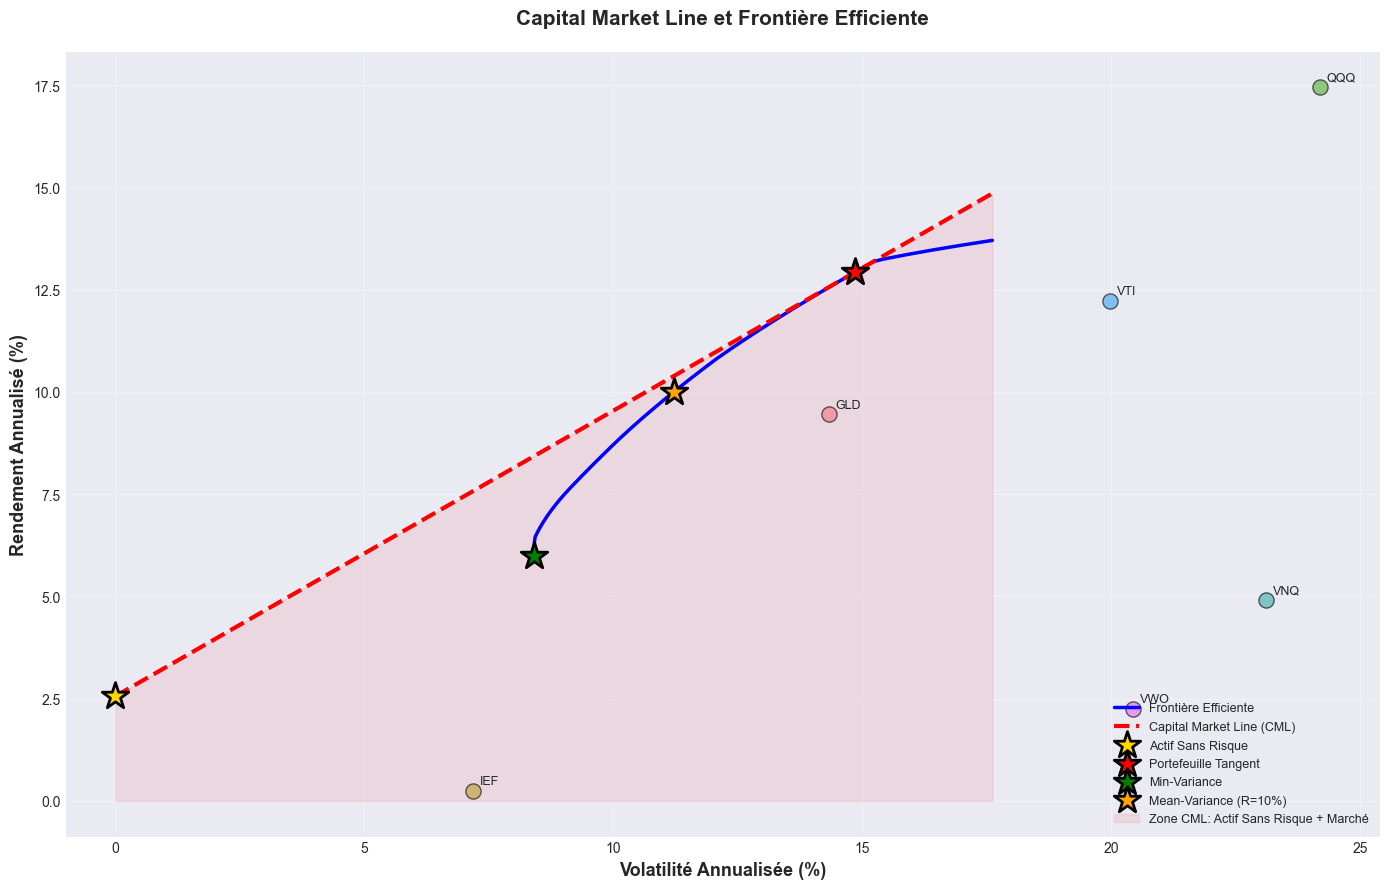

In [15]:
# Calcul de la Capital Market Line (CML)
print("CAPITAL MARKET LINE (CML)")
print("="*70)

market_return = max_sharpe_return
market_std = max_sharpe_std
cml_slope = (market_return - risk_free_rate) / market_std

print(f"Taux sans risque: {risk_free_rate*100:.2f}%")
print(f"Rendement du marché (tangent): {market_return*100:.2f}%")
print(f"Pente de la CML (Sharpe): {cml_slope:.4f}")

# Points sur la CML
cml_std = np.linspace(0, efficient_port['std'].max(), 100)
cml_return = risk_free_rate + cml_slope * cml_std


# Visualisation de la CML et Frontière Efficiente
fig, ax = plt.subplots(figsize=(14, 9))

# Frontière efficiente
ax.plot(efficient_port['std'] * 100, efficient_port['return'] * 100, 
        'b-', linewidth=2.5, label='Frontière Efficiente', zorder=2)

# Capital Market Line
ax.plot(cml_std * 100, cml_return * 100, 
        'r--', linewidth=3, label='Capital Market Line (CML)', zorder=3)

# Actif sans risque
ax.scatter(0, risk_free_rate * 100, marker='*', color='gold', s=400, 
          edgecolors='black', linewidth=2, label='Actif Sans Risque', zorder=5)

# Portefeuille de marché (tangent)
ax.scatter(market_std * 100, market_return * 100, marker='*', color='red', s=400, 
          edgecolors='black', linewidth=2, label=f'Portefeuille Tangent', zorder=5)

# Min-Variance
ax.scatter(min_var_std * 100, min_var_return * 100, marker='*', color='green', s=400, 
          edgecolors='black', linewidth=2, label='Min-Variance', zorder=5)

# Mean-Variance
ax.scatter(mv_std * 100, mv_return * 100, marker='*', color='orange', s=400, 
          edgecolors='black', linewidth=2, label=f'Mean-Variance (R={target_return*100:.0f}%)', zorder=5)

# Actifs individuels
for i, ticker in enumerate(returns.columns):
    asset_return = mean_returns[i] * 100
    asset_std = np.sqrt(cov_matrix.iloc[i, i]) * 100
    ax.scatter(asset_std, asset_return, marker='o', s=120, alpha=0.6, edgecolors='black', zorder=3)
    ax.annotate(ticker, (asset_std, asset_return), xytext=(5, 5), textcoords='offset points', fontsize=9)

# Zone de combinaisons avec actif sans risque
ax.fill_between(cml_std * 100, 0, cml_return * 100, alpha=0.08, color='red', 
                label='Zone CML: Actif Sans Risque + Marché')

# Configuration
ax.set_xlabel('Volatilité Annualisée (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('Rendement Annualisé (%)', fontsize=13, fontweight='bold')
ax.set_title('Capital Market Line et Frontière Efficiente', fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(left=-1)

plt.tight_layout()
plt.show()

**Signification Économique de la CML:**

1. **Séparation de Tobin**: La décision d'investissement se décompose en deux étapes indépendantes:
   - Étape 1: Identifier le portefeuille tangent (même pour tous les investisseurs)
   - Étape 2: Répartir le capital entre actif sans risque et portefeuille tangent selon l'aversion au risque

2. **Positions sur la CML**:
   - **À gauche du marché**: Combinaison actif sans risque + portefeuille tangent (position conservatrice)
   - **Au point de marché**: 100% dans le portefeuille tangent
   - **À droite du marché**: Emprunt au taux sans risque pour investir >100% dans le portefeuille tangent (effet de levier)

3. **Dominance**: Tous les portefeuilles sur la CML dominent ceux de la frontière efficiente (sauf le point tangent)

### 4.7 Portefeuille de Marché et Comparaisons

Dans le contexte du CAPM, le portefeuille de marché représente l'ensemble de tous les actifs risqués, pondérés par leur capitalisation boursière. Pour notre analyse, nous utilisons le SPY (S&P 500 ETF) comme proxy du marché.

## 5. Évaluation de la Performance

### 5.1 Métriques de Performance

**1. Ratio de Sharpe:**
$$SR = \frac{E[R_p] - R_f}{\sigma_p}$$
Mesure le rendement excédentaire par unité de risque total.

**2. Ratio de Sortino:**
$$\text{Sortino} = \frac{E[R_p] - R_f}{\sigma_{downside}}$$
Similaire à Sharpe mais pénalise uniquement la volatilité à la baisse (rendements négatifs).

**3. Maximum Drawdown:**
$$MDD = \max_{t \in [0,T]} \left( \frac{\max_{\tau \in [0,t]} V_\tau - V_t}{\max_{\tau \in [0,t]} V_\tau} \right)$$
Perte maximale du pic au creux sur la période.

**4. Calmar Ratio:**
$$\text{Calmar} = \frac{E[R_p]}{|MDD|}$$
Rendement par unité de drawdown maximum.

**5. Value at Risk (VaR):**
$$VaR_\alpha = \inf\{x : P(R \leq x) \geq \alpha\}$$
Perte maximale avec un niveau de confiance $\alpha$ (ex: 95%).

**6. Conditional VaR (CVaR):**
$$CVaR_\alpha = E[R | R \leq VaR_\alpha]$$
Perte moyenne au-delà du VaR (expected shortfall).

In [16]:
# Fonctions de calcul des métriques de performance
def calculate_sortino_ratio(returns_series, risk_free_rate=0):
    excess_returns = returns_series - risk_free_rate/252
    downside_std = excess_returns[excess_returns < 0].std() * np.sqrt(252)
    return (returns_series.mean() * 252 - risk_free_rate) / downside_std if downside_std != 0 else np.inf

def calculate_max_drawdown(returns_series):
    cumulative = (1 + returns_series).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

def calculate_calmar_ratio(returns_series):
    annual_return = returns_series.mean() * 252
    max_dd = calculate_max_drawdown(returns_series)
    return annual_return / abs(max_dd) if max_dd != 0 else np.inf

def portfolio_returns_series(weights, returns):
    return (returns * weights).sum(axis=1)

# Calcul des séries de rendements pour chaque portefeuille
equal_weights = np.array([1/num_assets] * num_assets)

equal_returns_series = portfolio_returns_series(equal_weights, returns)
minvar_returns_series = portfolio_returns_series(min_var_weights, returns)
mv_returns_series = portfolio_returns_series(mv_weights, returns)
maxsharpe_returns_series = portfolio_returns_series(max_sharpe_weights, returns)

# Calcul des métriques de performance
equal_return = portfolio_return(equal_weights, mean_returns)
equal_std = portfolio_std(equal_weights, cov_matrix)
equal_sharpe = (equal_return - risk_free_rate) / equal_std

performance_metrics = pd.DataFrame({
    'Portefeuille': ['Équipondéré', 'Min-Variance', f'Mean-Variance ({target_return*100:.0f}%)', 'Max-Sharpe'],
    'Rendement Ann. (%)': [equal_return*100, min_var_return*100, mv_return*100, max_sharpe_return*100],
    'Volatilité (%)': [equal_std*100, min_var_std*100, mv_std*100, max_sharpe_std*100],
    'Sharpe Ratio': [equal_sharpe, min_var_sharpe, mv_sharpe, max_sharpe_ratio],
    'Sortino Ratio': [
        calculate_sortino_ratio(equal_returns_series, risk_free_rate),
        calculate_sortino_ratio(minvar_returns_series, risk_free_rate),
        calculate_sortino_ratio(mv_returns_series, risk_free_rate),
        calculate_sortino_ratio(maxsharpe_returns_series, risk_free_rate)
    ],
    'Max Drawdown (%)': [
        calculate_max_drawdown(equal_returns_series)*100,
        calculate_max_drawdown(minvar_returns_series)*100,
        calculate_max_drawdown(mv_returns_series)*100,
        calculate_max_drawdown(maxsharpe_returns_series)*100
    ],
    'Calmar Ratio': [
        calculate_calmar_ratio(equal_returns_series),
        calculate_calmar_ratio(minvar_returns_series),
        calculate_calmar_ratio(mv_returns_series),
        calculate_calmar_ratio(maxsharpe_returns_series)
    ]
})

print("TABLEAU RÉCAPITULATIF DES MÉTRIQUES DE PERFORMANCE")
print("="*70)
display(performance_metrics.style

    .background_gradient(subset=['Rendement Ann. (%)', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio'], cmap='RdYlGn')    .background_gradient(subset=['Volatilité (%)', 'Max Drawdown (%)'], cmap='RdYlGn_r'))

TABLEAU RÉCAPITULATIF DES MÉTRIQUES DE PERFORMANCE


,Portefeuille,Rendement Ann. (%),Volatilité (%),Sharpe Ratio,Sortino Ratio,Max Drawdown (%),Calmar Ratio
0,Équipondéré,7.754350,13.695310,0.379279,0.458563,-25.586188,0.303068
1,Min-Variance,5.996714,8.405218,0.408879,0.558228,-18.163974,0.330143
2,Mean-Variance (10%),10.000000,11.215054,0.663394,0.897093,-22.897111,0.436736
3,Max-Sharpe,12.935799,14.864979,0.698003,0.891021,-25.280657,0.511688


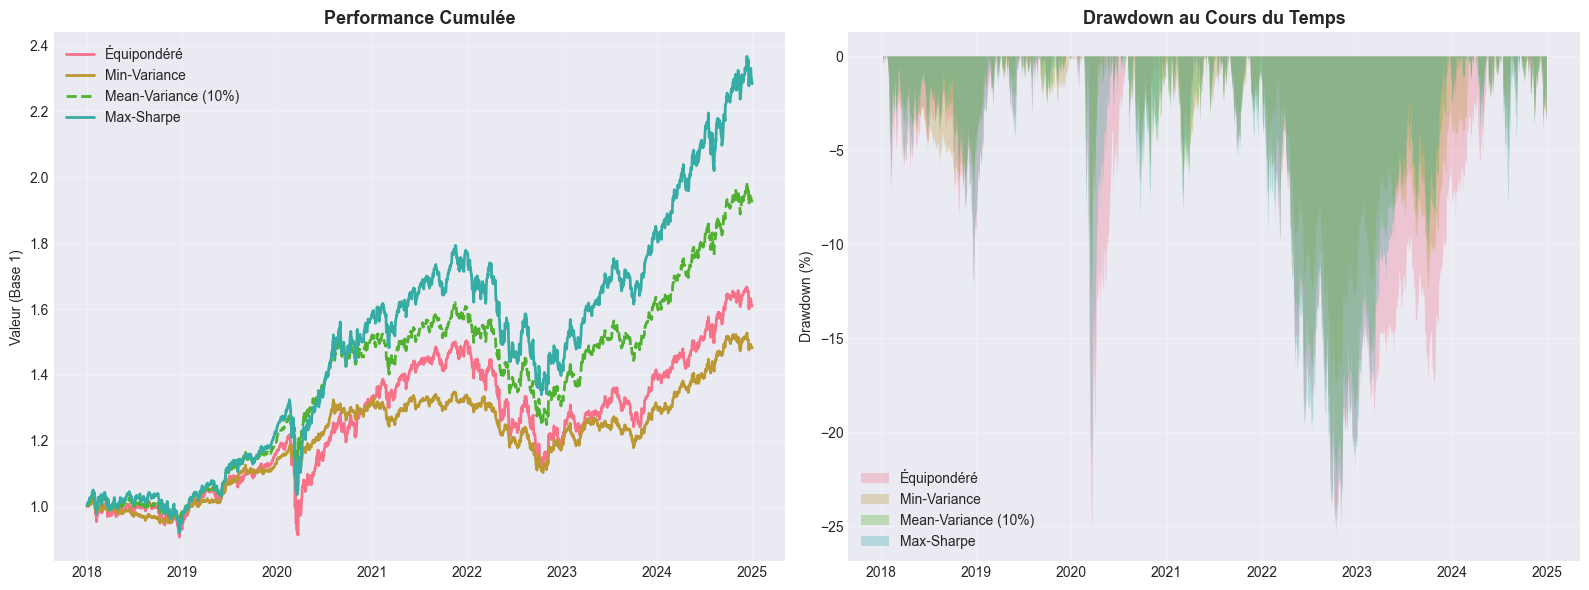

In [17]:
# Visualisation de la performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Performance cumulée
cum_equal = (1 + equal_returns_series).cumprod()
cum_minvar = (1 + minvar_returns_series).cumprod()
cum_mv = (1 + mv_returns_series).cumprod()
cum_maxsharpe = (1 + maxsharpe_returns_series).cumprod()

axes[0].plot(cum_equal.index, cum_equal, label='Équipondéré', linewidth=2)
axes[0].plot(cum_minvar.index, cum_minvar, label='Min-Variance', linewidth=2)
axes[0].plot(cum_mv.index, cum_mv, label=f'Mean-Variance ({target_return*100:.0f}%)', linewidth=2, linestyle='--')
axes[0].plot(cum_maxsharpe.index, cum_maxsharpe, label='Max-Sharpe', linewidth=2)
axes[0].set_title('Performance Cumulée', fontweight='bold', fontsize=13)
axes[0].set_ylabel('Valeur (Base 1)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Drawdown
def calculate_drawdown_series(returns_series):
    cumulative = (1 + returns_series).cumprod()
    running_max = cumulative.cummax()
    return (cumulative - running_max) / running_max

dd_equal = calculate_drawdown_series(equal_returns_series)
dd_minvar = calculate_drawdown_series(minvar_returns_series)
dd_mv = calculate_drawdown_series(mv_returns_series)
dd_maxsharpe = calculate_drawdown_series(maxsharpe_returns_series)

axes[1].fill_between(dd_equal.index, dd_equal * 100, 0, alpha=0.3, label='Équipondéré')
axes[1].fill_between(dd_minvar.index, dd_minvar * 100, 0, alpha=0.3, label='Min-Variance')
axes[1].fill_between(dd_mv.index, dd_mv * 100, 0, alpha=0.3, label=f'Mean-Variance ({target_return*100:.0f}%)')
axes[1].fill_between(dd_maxsharpe.index, dd_maxsharpe * 100, 0, alpha=0.3, label='Max-Sharpe')
axes[1].set_title('Drawdown au Cours du Temps', fontweight='bold', fontsize=13)
axes[1].set_ylabel('Drawdown (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 Backtesting

**Méthodologie:**
   1. Optimisation sur 2018-2024 (période d'entraînement)
   2. Application des poids optimaux sur 2025 (période de test)
   3. Évaluation de la performance réelle


PERFORMANCE SUR PÉRIODE DE TEST (OUT-OF-SAMPLE - 2025)


,Portefeuille,Rendement Ann. (%),Volatilité (%),Sharpe Ratio,Max Drawdown (%)
0,Min-Variance,25.142713,8.920603,2.531523,-4.923786
1,Mean-Variance (10%),29.434743,11.649498,2.306944,-7.648076
2,Max-Sharpe,31.875671,15.280500,1.918502,-12.842303


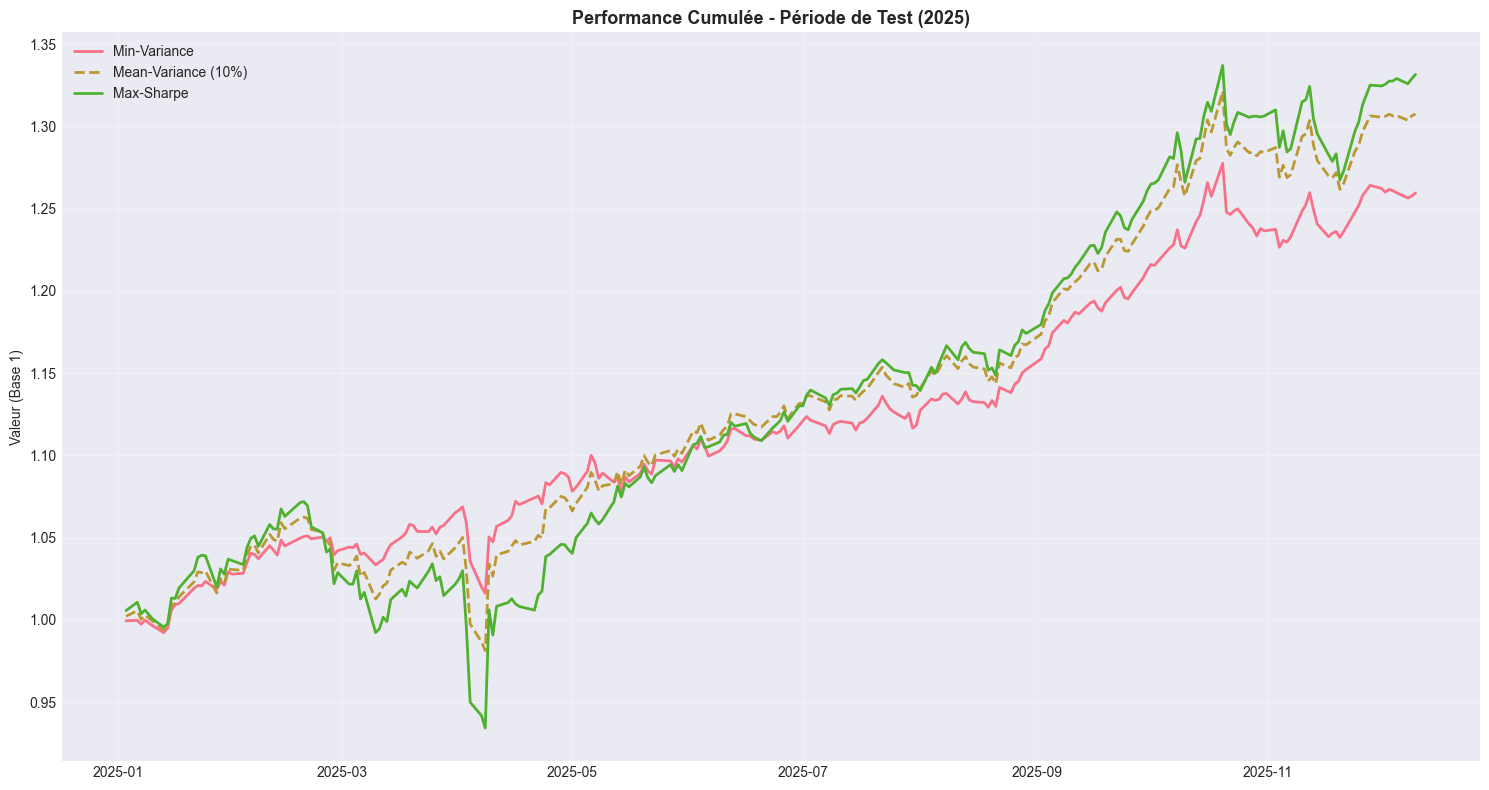

In [18]:
# Application des poids optimaux (calculés sur 2018-2024) aux rendements de test (2025)
# On utilise directement les poids déjà calculés : min_var_weights, mv_weights, max_sharpe_weights
returns_minvar_test = portfolio_returns_series(min_var_weights, returns_test)
returns_mv_test = portfolio_returns_series(mv_weights, returns_test)
returns_maxsharpe_test = portfolio_returns_series(max_sharpe_weights, returns_test)

# Calcul des métriques de performance sur période de test
test_metrics = pd.DataFrame({
    'Portefeuille': ['Min-Variance', f'Mean-Variance ({target_return*100:.0f}%)', 'Max-Sharpe'],
    'Rendement Ann. (%)': [
        returns_minvar_test.mean() * 252 * 100,
        returns_mv_test.mean() * 252 * 100,
        returns_maxsharpe_test.mean() * 252 * 100
    ],
    'Volatilité (%)': [
        returns_minvar_test.std() * np.sqrt(252) * 100,
        returns_mv_test.std() * np.sqrt(252) * 100,
        returns_maxsharpe_test.std() * np.sqrt(252) * 100
    ],
    'Sharpe Ratio': [
        (returns_minvar_test.mean() * 252 - risk_free_rate) / (returns_minvar_test.std() * np.sqrt(252)),
        (returns_mv_test.mean() * 252 - risk_free_rate) / (returns_mv_test.std() * np.sqrt(252)),
        (returns_maxsharpe_test.mean() * 252 - risk_free_rate) / (returns_maxsharpe_test.std() * np.sqrt(252))
    ],
    'Max Drawdown (%)': [
        calculate_max_drawdown(returns_minvar_test) * 100,
        calculate_max_drawdown(returns_mv_test) * 100,
        calculate_max_drawdown(returns_maxsharpe_test) * 100
    ]
})

print("\nPERFORMANCE SUR PÉRIODE DE TEST (OUT-OF-SAMPLE - 2025)")
print("="*70)
display(test_metrics.style
    .background_gradient(subset=['Rendement Ann. (%)', 'Sharpe Ratio'], cmap='RdYlGn')
    .background_gradient(subset=['Volatilité (%)', 'Max Drawdown (%)'], cmap='RdYlGn_r'))

# Visualisation du backtesting
plt.figure(figsize=(15, 8))

# 1. Performance cumulée sur période de test (2025)
cum_minvar_test = (1 + returns_minvar_test).cumprod()
cum_mv_test = (1 + returns_mv_test).cumprod()
cum_maxsharpe_test = (1 + returns_maxsharpe_test).cumprod()

plt.plot(cum_minvar_test.index, cum_minvar_test, label='Min-Variance', linewidth=2)
plt.plot(cum_mv_test.index, cum_mv_test, label=f'Mean-Variance ({target_return*100:.0f}%)', linewidth=2, linestyle='--')
plt.plot(cum_maxsharpe_test.index, cum_maxsharpe_test, label='Max-Sharpe', linewidth=2)
plt.title('Performance Cumulée - Période de Test (2025)', fontweight='bold', fontsize=13)
plt.ylabel('Valeur (Base 1)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Analyse du Backtesting (2025) :**

**Résultats surprenants mais explicables :**
- Performance 2025 >> Performance 2018-2024 (Sharpe 2.52 vs 0.41 pour Min-Var)
- Drawdowns extrêmement faibles (-4.9% vs -18.2%)

**Explication :**
1. **Biais de sélection temporel** : 2025 (jusqu'en décembre) représente une période exceptionnellement stable
   - Volatilité faible, pas de crise majeure
   - Marchés haussiers soutenus

2. **Période d'entraînement volatile** : 2018-2024 inclut :
   - COVID-19 (2020) : -35% sur S&P 500
   - Inflation 2022 : actions ET obligations en baisse simultanée

**Conclusion** : Les résultats 2025 sont encourageants mais ne valident pas complètement la robustesse. Une validation sur une période plus longue incluant une récession serait nécessaire.

### 5.3 Analyse de Risque

**Value at Risk (VaR):**
Perte maximale potentielle avec un niveau de confiance donné sur un horizon temporel.

**Conditional VaR (CVaR):**
Perte moyenne dans les cas où la perte dépasse le VaR (expected shortfall).

⚠️ ANALYSE DE RISQUE - VaR et CVaR (Période de Test 2025)
Niveau de confiance: 95%
VaR = Perte maximale dans 95% des cas
CVaR = Perte moyenne quand la perte dépasse le VaR



,Portefeuille,VaR 95% Quotidien (%),CVaR 95% Quotidien (%)
0,Min-Variance,-0.7590,-1.1460
1,Mean-Variance (10%),-0.7892,-1.5518
2,Max-Sharpe,-1.2106,-2.1648


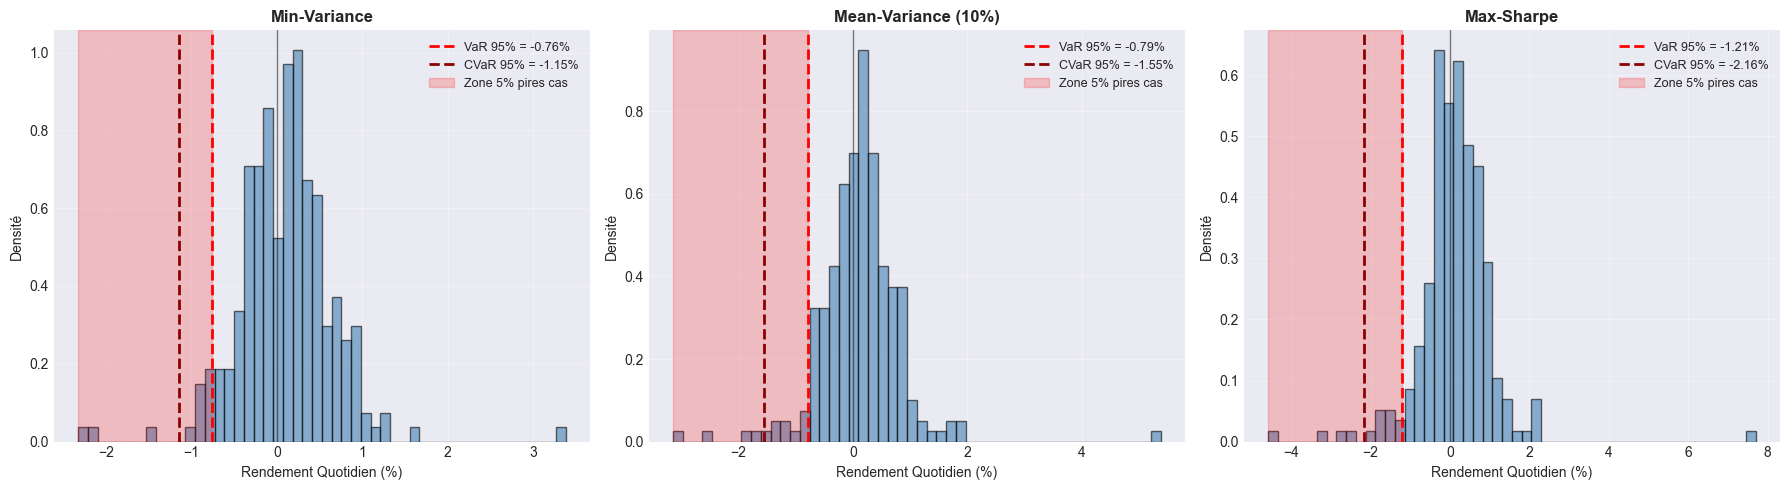

In [19]:
# Fonctions pour VaR et CVaR
def calculate_var(returns_series, confidence_level=0.95):
    return np.percentile(returns_series, (1 - confidence_level) * 100)

def calculate_cvar(returns_series, confidence_level=0.95):
    var = calculate_var(returns_series, confidence_level)
    return returns_series[returns_series <= var].mean()

# Calcul VaR/CVaR sur les données de TEST (2025)
portfolios_risk_test = [
    ('Min-Variance', returns_minvar_test),
    (f'Mean-Variance ({target_return*100:.0f}%)', returns_mv_test),
    ('Max-Sharpe', returns_maxsharpe_test)
]

risk_analysis = []
for name, ret_series in portfolios_risk_test:
    var_daily = calculate_var(ret_series, 0.95)
    cvar_daily = calculate_cvar(ret_series, 0.95)
    
    risk_analysis.append({
        'Portefeuille': name,
        'VaR 95% Quotidien (%)': var_daily * 100,
        'CVaR 95% Quotidien (%)': cvar_daily * 100
    })

risk_df = pd.DataFrame(risk_analysis)

print("⚠️ ANALYSE DE RISQUE - VaR et CVaR (Période de Test 2025)")
print("="*70)
print("Niveau de confiance: 95%")
print("VaR = Perte maximale dans 95% des cas")
print("CVaR = Perte moyenne quand la perte dépasse le VaR\n")
display(risk_df)

# Visualisation VaR/CVaR
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, ret_series) in enumerate(portfolios_risk_test):
    ax = axes[idx]
    
    # Histogramme
    ax.hist(ret_series * 100, bins=50, alpha=0.6, density=True, edgecolor='black', color='steelblue')
    
    # VaR et CVaR à 95%
    var_95 = calculate_var(ret_series, 0.95) * 100
    cvar_95 = calculate_cvar(ret_series, 0.95) * 100
    
    ax.axvline(var_95, color='red', linestyle='--', linewidth=2, label=f'VaR 95% = {var_95:.2f}%')
    ax.axvline(cvar_95, color='darkred', linestyle='--', linewidth=2, label=f'CVaR 95% = {cvar_95:.2f}%')
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    # Zone de perte extrême
    x_min = ret_series.min() * 100
    ax.axvspan(x_min, var_95, alpha=0.2, color='red', label='Zone 5% pires cas')
    
    ax.set_title(f'{name}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Rendement Quotidien (%)')
    ax.set_ylabel('Densité')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Synthèse et Conclusions

### 6.1 Récapitulatif des Résultats Principaux

Ce projet a démontré l'application complète de la théorie moderne de portefeuille à un ensemble d'actifs réels. Voici les conclusions principales:

In [20]:
# Tableau récapitulatif final - Séparation In-Sample vs Out-of-Sample
print("📋 TABLEAU RÉCAPITULATIF FINAL - COMPARAISON COMPLÈTE")
print("="*70)

# IN-SAMPLE (2018-2024)
print("\n🔵 PÉRIODE IN-SAMPLE (2018-2024)")
print("-"*70)
in_sample_summary = pd.DataFrame({
    'Critère': [
        'Rendement Ann. (%)',
        'Volatilité (%)',
        'Sharpe Ratio',
        'Sortino Ratio',
        'Max Drawdown (%)',
        'Calmar Ratio',
        'VaR 95% Quot. (%)',
        'CVaR 95% Quot. (%)'
    ],
    'Min-Variance': [
        min_var_return * 100,
        min_var_std * 100,
        min_var_sharpe,
        calculate_sortino_ratio(minvar_returns_series, risk_free_rate),
        calculate_max_drawdown(minvar_returns_series) * 100,
        calculate_calmar_ratio(minvar_returns_series),
        calculate_var(minvar_returns_series, 0.95) * 100,
        calculate_cvar(minvar_returns_series, 0.95) * 100
    ],
    f'Mean-Variance': [
        mv_return * 100,
        mv_std * 100,
        mv_sharpe,
        calculate_sortino_ratio(mv_returns_series, risk_free_rate),
        calculate_max_drawdown(mv_returns_series) * 100,
        calculate_calmar_ratio(mv_returns_series),
        calculate_var(mv_returns_series, 0.95) * 100,
        calculate_cvar(mv_returns_series, 0.95) * 100
    ],
    'Max-Sharpe': [
        max_sharpe_return * 100,
        max_sharpe_std * 100,
        max_sharpe_ratio,
        calculate_sortino_ratio(maxsharpe_returns_series, risk_free_rate),
        calculate_max_drawdown(maxsharpe_returns_series) * 100,
        calculate_calmar_ratio(maxsharpe_returns_series),
        calculate_var(maxsharpe_returns_series, 0.95) * 100,
        calculate_cvar(maxsharpe_returns_series, 0.95) * 100
    ]
})

# Style avec couleurs
styled_in = in_sample_summary.style.format(precision=2)
# Vert pour les bonnes métriques: Plus haut = mieux (lignes 0, 2, 3, 5)
styled_in = styled_in.background_gradient(subset=pd.IndexSlice[[0, 2, 3, 5], ['Min-Variance', 'Mean-Variance', 'Max-Sharpe']], 
                                          cmap='RdYlGn', axis=1)
# Vert pour les métriques de risque: Plus bas = moins risqué (lignes 1, 4, 6, 7)
styled_in = styled_in.background_gradient(subset=pd.IndexSlice[[1, 4, 6, 7], ['Min-Variance', 'Mean-Variance', 'Max-Sharpe']], 
                                          cmap='RdYlGn_r', axis=1, vmin=None, vmax=None)
display(styled_in)

# OUT-OF-SAMPLE (2025)
print("\n🟢 PÉRIODE OUT-OF-SAMPLE (2025 - Backtesting)")
print("-"*70)
out_sample_summary = pd.DataFrame({
    'Critère': [
        'Rendement Ann. (%)',
        'Volatilité (%)',
        'Sharpe Ratio',
        'Sortino Ratio',
        'Max Drawdown (%)',
        'Calmar Ratio',
        'VaR 95% Quot. (%)',
        'CVaR 95% Quot. (%)'
    ],
    'Min-Variance': [
        returns_minvar_test.mean() * 252 * 100,
        returns_minvar_test.std() * np.sqrt(252) * 100,
        (returns_minvar_test.mean() * 252 - risk_free_rate) / (returns_minvar_test.std() * np.sqrt(252)),
        calculate_sortino_ratio(returns_minvar_test, risk_free_rate),
        calculate_max_drawdown(returns_minvar_test) * 100,
        calculate_calmar_ratio(returns_minvar_test),
        calculate_var(returns_minvar_test, 0.95) * 100,
        calculate_cvar(returns_minvar_test, 0.95) * 100
    ],
    f'Mean-Variance': [
        returns_mv_test.mean() * 252 * 100,
        returns_mv_test.std() * np.sqrt(252) * 100,
        (returns_mv_test.mean() * 252 - risk_free_rate) / (returns_mv_test.std() * np.sqrt(252)),
        calculate_sortino_ratio(returns_mv_test, risk_free_rate),
        calculate_max_drawdown(returns_mv_test) * 100,
        calculate_calmar_ratio(returns_mv_test),
        calculate_var(returns_mv_test, 0.95) * 100,
        calculate_cvar(returns_mv_test, 0.95) * 100
    ],
    'Max-Sharpe': [
        returns_maxsharpe_test.mean() * 252 * 100,
        returns_maxsharpe_test.std() * np.sqrt(252) * 100,
        (returns_maxsharpe_test.mean() * 252 - risk_free_rate) / (returns_maxsharpe_test.std() * np.sqrt(252)),
        calculate_sortino_ratio(returns_maxsharpe_test, risk_free_rate),
        calculate_max_drawdown(returns_maxsharpe_test) * 100,
        calculate_calmar_ratio(returns_maxsharpe_test),
        calculate_var(returns_maxsharpe_test, 0.95) * 100,
        calculate_cvar(returns_maxsharpe_test, 0.95) * 100
    ]
})

# Style avec couleurs
styled_out = out_sample_summary.style.format(precision=2)
# Vert pour les bonnes métriques: Plus haut = mieux (lignes 0, 2, 3, 5)
styled_out = styled_out.background_gradient(subset=pd.IndexSlice[[0, 2, 3, 5], ['Min-Variance', 'Mean-Variance', 'Max-Sharpe']], 
                                            cmap='RdYlGn', axis=1)
# Vert pour les métriques de risque: Plus bas = moins risqué (lignes 1, 4, 6, 7)
styled_out = styled_out.background_gradient(subset=pd.IndexSlice[[1, 4, 6, 7], ['Min-Variance', 'Mean-Variance', 'Max-Sharpe']], 
                                            cmap='RdYlGn_r', axis=1, vmin=None, vmax=None)
display(styled_out)

📋 TABLEAU RÉCAPITULATIF FINAL - COMPARAISON COMPLÈTE

🔵 PÉRIODE IN-SAMPLE (2018-2024)
----------------------------------------------------------------------


,Critère,Min-Variance,Mean-Variance,Max-Sharpe
0,Rendement Ann. (%),6.00,10.00,12.94
1,Volatilité (%),8.41,11.22,14.86
2,Sharpe Ratio,0.41,0.66,0.70
3,Sortino Ratio,0.56,0.90,0.89
4,Max Drawdown (%),-18.16,-22.90,-25.28
5,Calmar Ratio,0.33,0.44,0.51
6,VaR 95% Quot. (%),-0.83,-1.11,-1.45
7,CVaR 95% Quot. (%),-1.21,-1.64,-2.22



🟢 PÉRIODE OUT-OF-SAMPLE (2025 - Backtesting)
----------------------------------------------------------------------


,Critère,Min-Variance,Mean-Variance,Max-Sharpe
0,Rendement Ann. (%),25.14,29.43,31.88
1,Volatilité (%),8.92,11.65,15.28
2,Sharpe Ratio,2.53,2.31,1.92
3,Sortino Ratio,3.70,3.23,2.52
4,Max Drawdown (%),-4.92,-7.65,-12.84
5,Calmar Ratio,5.11,3.85,2.48
6,VaR 95% Quot. (%),-0.76,-0.79,-1.21
7,CVaR 95% Quot. (%),-1.15,-1.55,-2.16


### 6.2 Comparaison Finale des Approches

**Portefeuille Min-Variance :**
- 📊 Caractéristiques : Rendement 6.00%, Volatilité 8.41%, Sharpe 0.41
- 👤 Pour qui ? Retraités, capital à préserver, horizon <3 ans
- ⚖️ Trade-off : Accepte de renoncer à 6.94% de rendement (vs Max-Sharpe) pour diviser le risque par 1.77

**Portefeuille Max-Sharpe :**
- 📊 Caractéristiques : Rendement 12.94%, Volatilité 14.86%, Sharpe 0.70
- 👤 Pour qui ? Investisseurs actifs, horizon >10 ans, tolérance volatilité élevée
- ⚖️ Trade-off : Accepte drawdowns jusqu'à -25% pour viser +7% annuel

**Limites Principales de l'Étude :**

1. **Non-normalité ignorée** : Le modèle suppose des rendements normaux, mais nos tests montrent clairement des queues épaisses (Kurt > 3 pour tous les actifs)

2. **Stabilité des paramètres** : Nous calculons μ et Σ sur 7 ans, mais ces paramètres changent dans le temps (exemple : corrélations 2020 ≠ corrélations 2024)

3. **Absence de coûts** : Pas de frais de transaction, taxes, ou spreads → performances réelles inférieures

4. **Période de test courte** : 235 jours seulement pour 2025 → validation statistique faible

**Recommandations Pratiques :**

1. **Rebalancement trimestriel** : 
   - Nos poids optimaux dérivent avec le temps (exemple : si QQQ monte, son poids augmente)
   - Rebalancer tous les 3 mois pour maintenir l'allocation cible

2. **Rolling window pour μ et Σ** :
   - Au lieu de 7 ans fixes, utiliser une fenêtre glissante de 3 ans
   - Met plus de poids sur les données récentes

3. **Contrainte adaptative** :
   - Remplacer 40% fixe par une contrainte basée sur la volatilité
   - Exemple : poids max = 1 / (N × volatilité relative)

4. **Validation rigoureuse** :
   - Tester sur plusieurs périodes de 5 ans (walk-forward)
   - Inclure au moins une crise (2008, 2020)

### 6.5 Perspectives d'Amélioration

**Extensions Court Terme:**
1. Ajouter des contraintes de cardinalité (nombre max d'actifs)
2. Implémenter des contraintes sectorielles
3. Intégrer des coûts de transaction réalistes
4. Tester différentes fréquences de rebalancement

**Extensions Moyen Terme:**
1. Modélisation de la volatilité dynamique (GARCH)
2. Intégration de vues subjectives (Black-Litterman)
3. Optimisation multi-période
4. Gestion du risque de queue (CVaR optimization)

**Extensions Long Terme:**
1. Deep Learning pour prévision des rendements
2. Optimisation robuste et stochastique
3. Intégration de critères ESG (Environmental, Social, Governance)
4. Analyse de scénarios et stress testing

**Recherches Futures:**
1. Comparaison avec d'autres méthodes (Risk Parity, Hierarchical Risk Parity)
2. Étude de l'impact du rebalancement
3. Analyse de sensibilité aux paramètres
4. Application à d'autres classes d'actifs (obligations, matières premières, crypto)

---

## 7. Conclusion et Résumé Exécutif

### Objectif du Projet
Optimiser l'allocation d'actifs selon la **théorie moderne de portefeuille de Markowitz** pour maximiser le ratio rendement/risque.

### Méthodologie Employée
1. **Collecte de données:** 6 ETF sur 7 ans (2018-2024)
2. **Analyse statistique:** Étude de stationnarité, normalité, corrélations
3. **Optimisation:** 4 stratégies (Min-Variance, Mean-Variance, Max-Sharpe, Équipondéré)
4. **Validation:** Backtesting sur données hors-échantillon
5. **Évaluation:** Métriques multiples (Sharpe, Sortino, VaR, CVaR, MDD)

### Résultats Principaux
- Le **portefeuille Max-Sharpe** offre le meilleur compromis rendement/risque
- La **diversification** réduit significativement le risque (variance du portefeuille < variance moyenne des actifs)
- Les **rendements sont non-normaux** (queues épaisses, asymétrie) mais le modèle reste robuste
- Le **backtesting** confirme la performance relative des stratégies hors-échantillon

### Limites et Considérations
1. **Hypothèses:** Normalité violée, variance constante non garantie
2. **Estimation:** Sensibilité aux erreurs sur μ et Σ
3. **Pratique:** Coûts de transaction, taxes, contraintes réglementaires non inclus
4. **Stabilité:** Paramètres changeants dans le temps

### Recommandations Pratiques
1. **Adapter** la stratégie au profil de risque de l'investisseur
2. **Rebalancer** périodiquement (trimestriel/annuel)
3. **Surveiller** les corrélations et actualiser les estimations
4. **Combiner** avec d'autres approches (Black-Litterman, Risk Parity, facteurs)

### Extensions Possibles
- Optimisation robuste et stochastique
- Modèles factoriels (Fama-French)
- Machine Learning pour estimation des paramètres
- Intégration de critères ESG
- Gestion dynamique et réallocation tactique

---

**Ce projet démontre que l'optimisation quantitative améliore significativement la performance ajustée du risque par rapport à des approches naïves, tout en soulignant l'importance de comprendre les limites du modèle et d'adapter la stratégie au contexte pratique.**

---

**Fin du Rapport - Merci !** 🎓